In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Mar 30 14:25:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 20%   35C    P0    32W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   32C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data
# For poca KDE
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import ThreeFeature_6Layer_XYPretrain_A as ModelA
from model.models_mjp_19November20 import ThreeFeature_6Layer_XYPretrain_E as ModelE
from model.models_mjp_19November20 import ThreeFeature_8Layer_XYPretrain_W as ModelW
from model.models_mjp_26December20 import ThreeFeature_10Layer_XYPretrain_X as ModelX
from model.models_mjp_26December20 import ThreeFeature_8Layer_XYPretrain_Y as ModelY
from model.models_mjp_30Jan21_AllCNN import ACN_3_P_10L_4S_BN as ModelXX

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/awkward/__init__.py:23: DeprecationWarning: Consider switching from 'awkward' to 'awkward1', since the new interface will become the default later this year (2020).

    pip install -U awkward1

In Python:

    >>> import awkward1 as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  DeprecationWarning


Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 1500, 1e-7, 1720)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

'''
## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
## 
                            #device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          #device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=True,
                          load_xy=True)
'''

## This is used when training with the new KDE
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=args.batch_size,
                            #device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=args.batch_size,
                            #device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 31.13 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 29.79 s
Constructing 160000 event dataset took 1.436 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 7.443 s
Constructing 20000 event dataset took 0.1873 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelXX()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/1814a2acb1ad42deaa08684cf5e2b1e4/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict, freeze_weights=False)

we also froze 0 weights
Of the 36.5 parameter layers to update in the current model, 36.5 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

ACN_3_P_10L_4S_BN(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(10, 1, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppFC): Linear(in_features=4000, out_fea

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


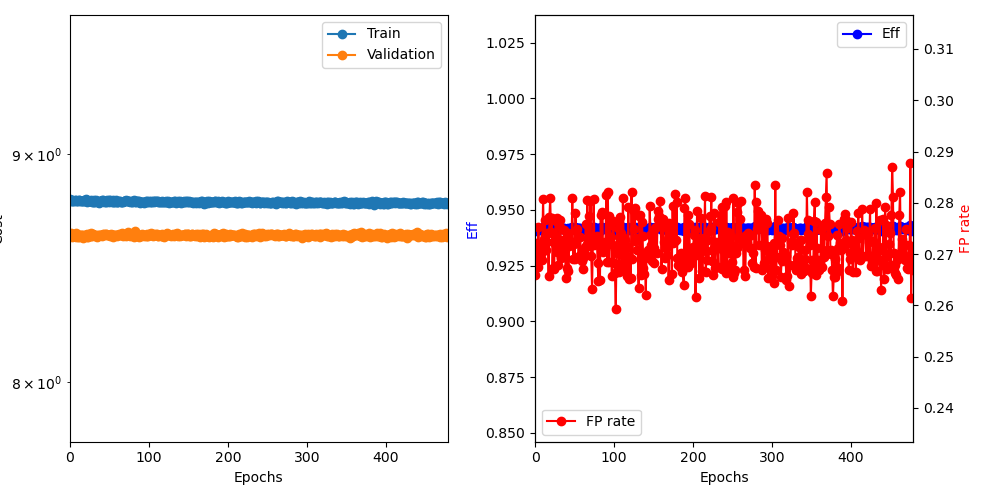

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [ ]:
avgEff=0
avgFP=0
print('for model: ', model)   
run_name = 'ACN_3_P_10L_4S_BN (P6)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '2.5')
        mlflow.set_tag('KDE', 'Poca')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

for model:  ACN_3_P_10L_4S_BN(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(10, 1, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppFC): Linear(in_features=4

/home/michael24peters/pv-finder/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 1720: train=8.79163, val=8.63358, took 72.896 s
  Validation Found 101601 of 108007, added 5319 (eff 94.07%) (0.266 FP/event)
Result epoch:  1720
Average Eff:  0
Average FP Rate:  0


Epoch 1721: train=8.78521, val=8.63729, took 72.193 s
  Validation Found 101664 of 108007, added 5443 (eff 94.13%) (0.272 FP/event)
Result epoch:  1721
Average Eff:  0
Average FP Rate:  0


Epoch 1722: train=8.78351, val=8.62313, took 72.395 s
  Validation Found 101654 of 108007, added 5412 (eff 94.12%) (0.271 FP/event)
Result epoch:  1722
Average Eff:  0
Average FP Rate:  0


Epoch 1723: train=8.78744, val=8.63162, took 72.09 s
  Validation Found 101627 of 108007, added 5350 (eff 94.09%) (0.267 FP/event)
Result epoch:  1723
Average Eff:  0
Average FP Rate:  0


Epoch 1724: train=8.78449, val=8.62909, took 72.066 s
  Validation Found 101719 of 108007, added 5507 (eff 94.18%) (0.275 FP/event)
Result epoch:  1724
Average Eff:  0
Average FP Rate:  0


Epoch 1725: train=8.78379, val=8.62378, took 72.723 s
  Validation Found 101649 of 108007, added 5393 (eff 94.11%) (0.27 FP/event)
Result epoch:  1725
Average Eff:  0
Average FP Rate:  0


Epoch 1726: train=8.78697, val=8.62715, took 71.6 s
  Validation Found 101659 of 108007, added 5421 (eff 94.12%) (0.271 FP/event)
Result epoch:  1726
Average Eff:  0
Average FP Rate:  0


Epoch 1727: train=8.78854, val=8.63849, took 71.835 s
  Validation Found 101651 of 108007, added 5400 (eff 94.12%) (0.27 FP/event)
Result epoch:  1727
Average Eff:  0
Average FP Rate:  0


Epoch 1728: train=8.78392, val=8.62192, took 71.906 s
  Validation Found 101648 of 108007, added 5377 (eff 94.11%) (0.269 FP/event)
Result epoch:  1728
Average Eff:  0
Average FP Rate:  0


Epoch 1729: train=8.78456, val=8.6244, took 71.834 s
  Validation Found 101680 of 108007, added 5436 (eff 94.14%) (0.272 FP/event)
Result epoch:  1729
Average Eff:  0
Average FP Rate:  0


Epoch 1730: train=8.78229, val=8.62153, took 71.082 s
  Validation Found 101770 of 108007, added 5616 (eff 94.23%) (0.281 FP/event)
Result epoch:  1730
Average Eff:  0
Average FP Rate:  0


Epoch 1731: train=8.78665, val=8.62307, took 72.111 s
  Validation Found 101689 of 108007, added 5459 (eff 94.15%) (0.273 FP/event)
Result epoch:  1731
Average Eff:  0
Average FP Rate:  0


Epoch 1732: train=8.78593, val=8.62986, took 70.617 s
  Validation Found 101739 of 108007, added 5532 (eff 94.20%) (0.277 FP/event)
Result epoch:  1732
Average Eff:  0
Average FP Rate:  0


Epoch 1733: train=8.78556, val=8.6322, took 72.148 s
  Validation Found 101697 of 108007, added 5470 (eff 94.16%) (0.273 FP/event)
Result epoch:  1733
Average Eff:  0
Average FP Rate:  0


Epoch 1734: train=8.78305, val=8.63195, took 72.301 s
  Validation Found 101677 of 108007, added 5416 (eff 94.14%) (0.271 FP/event)
Result epoch:  1734
Average Eff:  0
Average FP Rate:  0


Epoch 1735: train=8.78269, val=8.63257, took 71.091 s
  Validation Found 101715 of 108007, added 5481 (eff 94.17%) (0.274 FP/event)
Result epoch:  1735
Average Eff:  0
Average FP Rate:  0


Epoch 1736: train=8.7845, val=8.61863, took 71.014 s
  Validation Found 101731 of 108007, added 5484 (eff 94.19%) (0.274 FP/event)
Result epoch:  1736
Average Eff:  0
Average FP Rate:  0


Epoch 1737: train=8.78393, val=8.63142, took 71.051 s
  Validation Found 101602 of 108007, added 5316 (eff 94.07%) (0.266 FP/event)
Result epoch:  1737
Average Eff:  0
Average FP Rate:  0


Epoch 1738: train=8.7874, val=8.62521, took 70.921 s
  Validation Found 101758 of 108007, added 5546 (eff 94.21%) (0.277 FP/event)
Result epoch:  1738
Average Eff:  0
Average FP Rate:  0


Epoch 1739: train=8.78263, val=8.63215, took 70.744 s
  Validation Found 101782 of 108007, added 5618 (eff 94.24%) (0.281 FP/event)
Result epoch:  1739
Average Eff:  0
Average FP Rate:  0


Epoch 1740: train=8.79087, val=8.63049, took 71.885 s
  Validation Found 101728 of 108007, added 5486 (eff 94.19%) (0.274 FP/event)
Result epoch:  1740
Average Eff:  0
Average FP Rate:  0


Epoch 1741: train=8.78066, val=8.62252, took 72.926 s
  Validation Found 101760 of 108007, added 5540 (eff 94.22%) (0.277 FP/event)
Result epoch:  1741
Average Eff:  0
Average FP Rate:  0


Epoch 1742: train=8.78828, val=8.63281, took 71.551 s
  Validation Found 101624 of 108007, added 5346 (eff 94.09%) (0.267 FP/event)
Result epoch:  1742
Average Eff:  0
Average FP Rate:  0


Epoch 1743: train=8.7846, val=8.62017, took 71.583 s
  Validation Found 101714 of 108007, added 5449 (eff 94.17%) (0.272 FP/event)
Result epoch:  1743
Average Eff:  0
Average FP Rate:  0


Epoch 1744: train=8.78502, val=8.63502, took 70.726 s
  Validation Found 101636 of 108007, added 5342 (eff 94.10%) (0.267 FP/event)
Result epoch:  1744
Average Eff:  0
Average FP Rate:  0


Epoch 1745: train=8.78354, val=8.62968, took 70.746 s
  Validation Found 101726 of 108007, added 5476 (eff 94.18%) (0.274 FP/event)
Result epoch:  1745
Average Eff:  0
Average FP Rate:  0


Epoch 1746: train=8.78532, val=8.62785, took 70.565 s
  Validation Found 101757 of 108007, added 5528 (eff 94.21%) (0.276 FP/event)
Result epoch:  1746
Average Eff:  0
Average FP Rate:  0


Epoch 1747: train=8.78649, val=8.63806, took 71.029 s
  Validation Found 101758 of 108007, added 5542 (eff 94.21%) (0.277 FP/event)
Result epoch:  1747
Average Eff:  0
Average FP Rate:  0


Epoch 1748: train=8.77908, val=8.62776, took 70.858 s
  Validation Found 101681 of 108007, added 5408 (eff 94.14%) (0.27 FP/event)
Result epoch:  1748
Average Eff:  0
Average FP Rate:  0


Epoch 1749: train=8.77955, val=8.63583, took 72.111 s
  Validation Found 101645 of 108007, added 5359 (eff 94.11%) (0.268 FP/event)
Result epoch:  1749
Average Eff:  0
Average FP Rate:  0


Epoch 1750: train=8.78581, val=8.63107, took 72.629 s
  Validation Found 101693 of 108007, added 5426 (eff 94.15%) (0.271 FP/event)
Result epoch:  1750
Average Eff:  0
Average FP Rate:  0


Epoch 1751: train=8.77817, val=8.63091, took 72.862 s
  Validation Found 101751 of 108007, added 5535 (eff 94.21%) (0.277 FP/event)
Result epoch:  1751
Average Eff:  0
Average FP Rate:  0


Epoch 1752: train=8.77989, val=8.62664, took 72.307 s
  Validation Found 101729 of 108007, added 5504 (eff 94.19%) (0.275 FP/event)
Result epoch:  1752
Average Eff:  0
Average FP Rate:  0


Epoch 1753: train=8.78617, val=8.63071, took 72.533 s
  Validation Found 101675 of 108007, added 5383 (eff 94.14%) (0.269 FP/event)
Result epoch:  1753
Average Eff:  0
Average FP Rate:  0


Epoch 1754: train=8.78166, val=8.62312, took 72.553 s
  Validation Found 101715 of 108007, added 5456 (eff 94.17%) (0.273 FP/event)
Result epoch:  1754
Average Eff:  0
Average FP Rate:  0


Epoch 1755: train=8.7805, val=8.62595, took 72.824 s
  Validation Found 101711 of 108007, added 5449 (eff 94.17%) (0.272 FP/event)
Result epoch:  1755
Average Eff:  0
Average FP Rate:  0


Epoch 1756: train=8.77985, val=8.62938, took 72.52 s
  Validation Found 101679 of 108007, added 5398 (eff 94.14%) (0.27 FP/event)
Result epoch:  1756
Average Eff:  0
Average FP Rate:  0


Epoch 1757: train=8.77382, val=8.62879, took 72.4 s
  Validation Found 101750 of 108007, added 5493 (eff 94.21%) (0.275 FP/event)
Result epoch:  1757
Average Eff:  0
Average FP Rate:  0


Epoch 1758: train=8.78363, val=8.62931, took 71.297 s
  Validation Found 101670 of 108007, added 5387 (eff 94.13%) (0.269 FP/event)
Result epoch:  1758
Average Eff:  0
Average FP Rate:  0


Epoch 1759: train=8.78256, val=8.62834, took 71.052 s
  Validation Found 101638 of 108007, added 5308 (eff 94.10%) (0.265 FP/event)
Result epoch:  1759
Average Eff:  0
Average FP Rate:  0


Epoch 1760: train=8.7864, val=8.62563, took 72.677 s
  Validation Found 101671 of 108007, added 5346 (eff 94.13%) (0.267 FP/event)
Result epoch:  1760
Average Eff:  0
Average FP Rate:  0


Epoch 1761: train=8.7838, val=8.63249, took 72.804 s
  Validation Found 101734 of 108007, added 5481 (eff 94.19%) (0.274 FP/event)
Result epoch:  1761
Average Eff:  0
Average FP Rate:  0


Epoch 1762: train=8.78629, val=8.63598, took 72.242 s
  Validation Found 101621 of 108007, added 5336 (eff 94.09%) (0.267 FP/event)
Result epoch:  1762
Average Eff:  0
Average FP Rate:  0


Epoch 1763: train=8.78109, val=8.63299, took 73.299 s
  Validation Found 101702 of 108007, added 5433 (eff 94.16%) (0.272 FP/event)
Result epoch:  1763
Average Eff:  0
Average FP Rate:  0


Epoch 1764: train=8.7817, val=8.63112, took 72.507 s
  Validation Found 101718 of 108007, added 5450 (eff 94.18%) (0.272 FP/event)
Result epoch:  1764
Average Eff:  0
Average FP Rate:  0


Epoch 1765: train=8.77883, val=8.63335, took 72.241 s
  Validation Found 101717 of 108007, added 5448 (eff 94.18%) (0.272 FP/event)
Result epoch:  1765
Average Eff:  0
Average FP Rate:  0


Epoch 1766: train=8.78036, val=8.63403, took 72.095 s
  Validation Found 101715 of 108007, added 5438 (eff 94.17%) (0.272 FP/event)
Result epoch:  1766
Average Eff:  0
Average FP Rate:  0


Epoch 1767: train=8.7864, val=8.62953, took 72.763 s
  Validation Found 101777 of 108007, added 5617 (eff 94.23%) (0.281 FP/event)
Result epoch:  1767
Average Eff:  0
Average FP Rate:  0


Epoch 1768: train=8.78213, val=8.6283, took 72.417 s
  Validation Found 101676 of 108007, added 5381 (eff 94.14%) (0.269 FP/event)
Result epoch:  1768
Average Eff:  0
Average FP Rate:  0


Epoch 1769: train=8.77977, val=8.63026, took 73.34 s
  Validation Found 101715 of 108007, added 5440 (eff 94.17%) (0.272 FP/event)
Result epoch:  1769
Average Eff:  0
Average FP Rate:  0


Epoch 1770: train=8.78644, val=8.6314, took 71.224 s
  Validation Found 101676 of 108007, added 5380 (eff 94.14%) (0.269 FP/event)
Result epoch:  1770
Average Eff:  0
Average FP Rate:  0


Epoch 1771: train=8.78764, val=8.62788, took 71.803 s
  Validation Found 101764 of 108007, added 5562 (eff 94.22%) (0.278 FP/event)
Result epoch:  1771
Average Eff:  0
Average FP Rate:  0


Epoch 1772: train=8.78455, val=8.63373, took 70.659 s
  Validation Found 101734 of 108007, added 5492 (eff 94.19%) (0.275 FP/event)
Result epoch:  1772
Average Eff:  0
Average FP Rate:  0


Epoch 1773: train=8.78011, val=8.62974, took 71.07 s
  Validation Found 101736 of 108007, added 5497 (eff 94.19%) (0.275 FP/event)
Result epoch:  1773
Average Eff:  0
Average FP Rate:  0


Epoch 1774: train=8.78018, val=8.63236, took 70.867 s
  Validation Found 101731 of 108007, added 5468 (eff 94.19%) (0.273 FP/event)
Result epoch:  1774
Average Eff:  0
Average FP Rate:  0


Epoch 1775: train=8.78771, val=8.62052, took 71.199 s
  Validation Found 101700 of 108007, added 5393 (eff 94.16%) (0.27 FP/event)
Result epoch:  1775
Average Eff:  0
Average FP Rate:  0


Epoch 1776: train=8.78039, val=8.6289, took 71.416 s
  Validation Found 101735 of 108007, added 5466 (eff 94.19%) (0.273 FP/event)
Result epoch:  1776
Average Eff:  0
Average FP Rate:  0


Epoch 1777: train=8.77929, val=8.63113, took 71.484 s
  Validation Found 101728 of 108007, added 5468 (eff 94.19%) (0.273 FP/event)
Result epoch:  1777
Average Eff:  0
Average FP Rate:  0


Epoch 1778: train=8.78611, val=8.62855, took 71.291 s
  Validation Found 101672 of 108007, added 5381 (eff 94.13%) (0.269 FP/event)
Result epoch:  1778
Average Eff:  0
Average FP Rate:  0


Epoch 1779: train=8.77838, val=8.62802, took 72.549 s
  Validation Found 101666 of 108007, added 5373 (eff 94.13%) (0.269 FP/event)
Result epoch:  1779
Average Eff:  0
Average FP Rate:  0


Epoch 1780: train=8.7775, val=8.63163, took 72.725 s
  Validation Found 101668 of 108007, added 5383 (eff 94.13%) (0.269 FP/event)
Result epoch:  1780
Average Eff:  0
Average FP Rate:  0


Epoch 1781: train=8.77902, val=8.63209, took 73.102 s
  Validation Found 101652 of 108007, added 5343 (eff 94.12%) (0.267 FP/event)
Result epoch:  1781
Average Eff:  0
Average FP Rate:  0


Epoch 1782: train=8.78219, val=8.63449, took 72.134 s
  Validation Found 101683 of 108007, added 5413 (eff 94.14%) (0.271 FP/event)
Result epoch:  1782
Average Eff:  0
Average FP Rate:  0


Epoch 1783: train=8.78194, val=8.63217, took 72.283 s
  Validation Found 101704 of 108007, added 5426 (eff 94.16%) (0.271 FP/event)
Result epoch:  1783
Average Eff:  0
Average FP Rate:  0


Epoch 1784: train=8.77789, val=8.63328, took 70.8 s
  Validation Found 101739 of 108007, added 5519 (eff 94.20%) (0.276 FP/event)
Result epoch:  1784
Average Eff:  0
Average FP Rate:  0


Epoch 1785: train=8.78039, val=8.63201, took 72.458 s
  Validation Found 101715 of 108007, added 5440 (eff 94.17%) (0.272 FP/event)
Result epoch:  1785
Average Eff:  0
Average FP Rate:  0


Epoch 1786: train=8.77763, val=8.6374, took 71.618 s
  Validation Found 101774 of 108007, added 5611 (eff 94.23%) (0.281 FP/event)
Result epoch:  1786
Average Eff:  0
Average FP Rate:  0


Epoch 1787: train=8.77782, val=8.62563, took 72.438 s
  Validation Found 101726 of 108007, added 5455 (eff 94.18%) (0.273 FP/event)
Result epoch:  1787
Average Eff:  0
Average FP Rate:  0


Epoch 1788: train=8.78267, val=8.6324, took 72.407 s
  Validation Found 101749 of 108007, added 5549 (eff 94.21%) (0.277 FP/event)
Result epoch:  1788
Average Eff:  0
Average FP Rate:  0


Epoch 1789: train=8.7839, val=8.63047, took 71.648 s
  Validation Found 101697 of 108007, added 5431 (eff 94.16%) (0.272 FP/event)
Result epoch:  1789
Average Eff:  0
Average FP Rate:  0


Epoch 1790: train=8.78498, val=8.63482, took 71.88 s
  Validation Found 101781 of 108007, added 5607 (eff 94.24%) (0.28 FP/event)
Result epoch:  1790
Average Eff:  0
Average FP Rate:  0


Epoch 1791: train=8.78664, val=8.62482, took 71.353 s
  Validation Found 101691 of 108007, added 5391 (eff 94.15%) (0.27 FP/event)
Result epoch:  1791
Average Eff:  0
Average FP Rate:  0


Epoch 1792: train=8.7835, val=8.63445, took 70.702 s
  Validation Found 101581 of 108007, added 5264 (eff 94.05%) (0.263 FP/event)
Result epoch:  1792
Average Eff:  0
Average FP Rate:  0


Epoch 1793: train=8.78526, val=8.62876, took 70.864 s
  Validation Found 101730 of 108007, added 5452 (eff 94.19%) (0.273 FP/event)
Result epoch:  1793
Average Eff:  0
Average FP Rate:  0


Epoch 1794: train=8.78254, val=8.64243, took 70.826 s
  Validation Found 101786 of 108007, added 5616 (eff 94.24%) (0.281 FP/event)
Result epoch:  1794
Average Eff:  0
Average FP Rate:  0


Epoch 1795: train=8.78127, val=8.63073, took 71.924 s
  Validation Found 101713 of 108007, added 5435 (eff 94.17%) (0.272 FP/event)
Result epoch:  1795
Average Eff:  0
Average FP Rate:  0


Epoch 1796: train=8.78037, val=8.62425, took 72.255 s
  Validation Found 101724 of 108007, added 5463 (eff 94.18%) (0.273 FP/event)
Result epoch:  1796
Average Eff:  0
Average FP Rate:  0


Epoch 1797: train=8.78309, val=8.62876, took 72.182 s
  Validation Found 101725 of 108007, added 5445 (eff 94.18%) (0.272 FP/event)
Result epoch:  1797
Average Eff:  0
Average FP Rate:  0


Epoch 1798: train=8.78074, val=8.63296, took 71.739 s
  Validation Found 101729 of 108007, added 5470 (eff 94.19%) (0.273 FP/event)
Result epoch:  1798
Average Eff:  0
Average FP Rate:  0


Epoch 1799: train=8.77669, val=8.63445, took 71.257 s
  Validation Found 101655 of 108007, added 5367 (eff 94.12%) (0.268 FP/event)
Result epoch:  1799
Average Eff:  0
Average FP Rate:  0


Epoch 1800: train=8.78122, val=8.63338, took 71.725 s
  Validation Found 101600 of 108007, added 5296 (eff 94.07%) (0.265 FP/event)
Result epoch:  1800
Average Eff:  0
Average FP Rate:  0


Epoch 1801: train=8.78754, val=8.62121, took 72.747 s
  Validation Found 101729 of 108007, added 5439 (eff 94.19%) (0.272 FP/event)
Result epoch:  1801
Average Eff:  0
Average FP Rate:  0


Epoch 1802: train=8.78101, val=8.64735, took 72.203 s
  Validation Found 101590 of 108007, added 5300 (eff 94.06%) (0.265 FP/event)
Result epoch:  1802
Average Eff:  0
Average FP Rate:  0


Epoch 1803: train=8.78035, val=8.62614, took 72.173 s
  Validation Found 101762 of 108007, added 5551 (eff 94.22%) (0.278 FP/event)
Result epoch:  1803
Average Eff:  0
Average FP Rate:  0


Epoch 1804: train=8.78177, val=8.63612, took 71.616 s
  Validation Found 101705 of 108007, added 5432 (eff 94.17%) (0.272 FP/event)
Result epoch:  1804
Average Eff:  0
Average FP Rate:  0


Epoch 1805: train=8.78475, val=8.63445, took 71.733 s
  Validation Found 101769 of 108007, added 5566 (eff 94.22%) (0.278 FP/event)
Result epoch:  1805
Average Eff:  0
Average FP Rate:  0


Epoch 1806: train=8.78295, val=8.63038, took 72.309 s
  Validation Found 101698 of 108007, added 5409 (eff 94.16%) (0.27 FP/event)
Result epoch:  1806
Average Eff:  0
Average FP Rate:  0


Epoch 1807: train=8.78237, val=8.62942, took 72.575 s
  Validation Found 101715 of 108007, added 5433 (eff 94.17%) (0.272 FP/event)
Result epoch:  1807
Average Eff:  0
Average FP Rate:  0


Epoch 1808: train=8.7798, val=8.62349, took 71.467 s
  Validation Found 101710 of 108007, added 5419 (eff 94.17%) (0.271 FP/event)
Result epoch:  1808
Average Eff:  0
Average FP Rate:  0


Epoch 1809: train=8.77602, val=8.62699, took 71.353 s
  Validation Found 101718 of 108007, added 5448 (eff 94.18%) (0.272 FP/event)
Result epoch:  1809
Average Eff:  0
Average FP Rate:  0


Epoch 1810: train=8.78086, val=8.62621, took 71.157 s
  Validation Found 101788 of 108007, added 5632 (eff 94.24%) (0.282 FP/event)
Result epoch:  1810
Average Eff:  0
Average FP Rate:  0


Epoch 1811: train=8.77963, val=8.63567, took 70.937 s
  Validation Found 101657 of 108007, added 5371 (eff 94.12%) (0.269 FP/event)
Result epoch:  1811
Average Eff:  0
Average FP Rate:  0


Epoch 1812: train=8.7772, val=8.6294, took 71.161 s
  Validation Found 101800 of 108007, added 5641 (eff 94.25%) (0.282 FP/event)
Result epoch:  1812
Average Eff:  0
Average FP Rate:  0


Epoch 1813: train=8.77858, val=8.63109, took 71.979 s
  Validation Found 101683 of 108007, added 5371 (eff 94.14%) (0.269 FP/event)
Result epoch:  1813
Average Eff:  0
Average FP Rate:  0


Epoch 1814: train=8.77624, val=8.62763, took 71.439 s
  Validation Found 101772 of 108007, added 5550 (eff 94.23%) (0.277 FP/event)
Result epoch:  1814
Average Eff:  0
Average FP Rate:  0


Epoch 1815: train=8.77987, val=8.63131, took 72.987 s
  Validation Found 101740 of 108007, added 5515 (eff 94.20%) (0.276 FP/event)
Result epoch:  1815
Average Eff:  0
Average FP Rate:  0


Epoch 1816: train=8.78553, val=8.62646, took 72.134 s
  Validation Found 101732 of 108007, added 5466 (eff 94.19%) (0.273 FP/event)
Result epoch:  1816
Average Eff:  0
Average FP Rate:  0


Epoch 1817: train=8.78239, val=8.62539, took 72.099 s
  Validation Found 101617 of 108007, added 5315 (eff 94.08%) (0.266 FP/event)
Result epoch:  1817
Average Eff:  0
Average FP Rate:  0


Epoch 1818: train=8.77964, val=8.6359, took 72.012 s
  Validation Found 101713 of 108007, added 5436 (eff 94.17%) (0.272 FP/event)
Result epoch:  1818
Average Eff:  0
Average FP Rate:  0


Epoch 1819: train=8.77756, val=8.62704, took 71.694 s
  Validation Found 101755 of 108007, added 5528 (eff 94.21%) (0.276 FP/event)
Result epoch:  1819
Average Eff:  0
Average FP Rate:  0


Epoch 1820: train=8.78412, val=8.63302, took 71.627 s
  Validation Found 101648 of 108007, added 5366 (eff 94.11%) (0.268 FP/event)
Result epoch:  1820
Average Eff:  0
Average FP Rate:  0


Epoch 1821: train=8.78047, val=8.63642, took 72.316 s
  Validation Found 101639 of 108007, added 5325 (eff 94.10%) (0.266 FP/event)
Result epoch:  1821
Average Eff:  0
Average FP Rate:  0


Epoch 1822: train=8.77946, val=8.63957, took 72.232 s
  Validation Found 101531 of 108007, added 5187 (eff 94.00%) (0.259 FP/event)
Result epoch:  1822
Average Eff:  0
Average FP Rate:  0


Epoch 1823: train=8.78227, val=8.62956, took 72.609 s
  Validation Found 101709 of 108007, added 5403 (eff 94.17%) (0.27 FP/event)
Result epoch:  1823
Average Eff:  0
Average FP Rate:  0


Epoch 1824: train=8.77841, val=8.6305, took 72.247 s
  Validation Found 101737 of 108007, added 5525 (eff 94.19%) (0.276 FP/event)
Result epoch:  1824
Average Eff:  0
Average FP Rate:  0


Epoch 1825: train=8.78396, val=8.62497, took 71.609 s
  Validation Found 101752 of 108007, added 5501 (eff 94.21%) (0.275 FP/event)
Result epoch:  1825
Average Eff:  0
Average FP Rate:  0


Epoch 1826: train=8.77935, val=8.62994, took 71.706 s
  Validation Found 101647 of 108007, added 5331 (eff 94.11%) (0.267 FP/event)
Result epoch:  1826
Average Eff:  0
Average FP Rate:  0


Epoch 1827: train=8.7818, val=8.63371, took 71.888 s
  Validation Found 101666 of 108007, added 5344 (eff 94.13%) (0.267 FP/event)
Result epoch:  1827
Average Eff:  0
Average FP Rate:  0


Epoch 1828: train=8.78156, val=8.63184, took 72.165 s
  Validation Found 101756 of 108007, added 5544 (eff 94.21%) (0.277 FP/event)
Result epoch:  1828
Average Eff:  0
Average FP Rate:  0


Epoch 1829: train=8.78168, val=8.63322, took 72.292 s
  Validation Found 101736 of 108007, added 5484 (eff 94.19%) (0.274 FP/event)
Result epoch:  1829
Average Eff:  0
Average FP Rate:  0


Epoch 1830: train=8.78172, val=8.6346, took 71.576 s
  Validation Found 101669 of 108007, added 5361 (eff 94.13%) (0.268 FP/event)
Result epoch:  1830
Average Eff:  0
Average FP Rate:  0


Epoch 1831: train=8.78268, val=8.62729, took 73.296 s
  Validation Found 101792 of 108007, added 5617 (eff 94.25%) (0.281 FP/event)
Result epoch:  1831
Average Eff:  0
Average FP Rate:  0


Epoch 1832: train=8.77903, val=8.62787, took 72.627 s
  Validation Found 101726 of 108007, added 5462 (eff 94.18%) (0.273 FP/event)
Result epoch:  1832
Average Eff:  0
Average FP Rate:  0


Epoch 1833: train=8.78093, val=8.6309, took 72.542 s
  Validation Found 101636 of 108007, added 5334 (eff 94.10%) (0.267 FP/event)
Result epoch:  1833
Average Eff:  0
Average FP Rate:  0


Epoch 1834: train=8.77818, val=8.62941, took 72.351 s
  Validation Found 101725 of 108007, added 5455 (eff 94.18%) (0.273 FP/event)
Result epoch:  1834
Average Eff:  0
Average FP Rate:  0


Epoch 1835: train=8.77945, val=8.62667, took 72.283 s
  Validation Found 101671 of 108007, added 5348 (eff 94.13%) (0.267 FP/event)
Result epoch:  1835
Average Eff:  0
Average FP Rate:  0


Epoch 1836: train=8.77963, val=8.62816, took 72.008 s
  Validation Found 101618 of 108007, added 5314 (eff 94.08%) (0.266 FP/event)
Result epoch:  1836
Average Eff:  0
Average FP Rate:  0


Epoch 1837: train=8.7817, val=8.63592, took 72.028 s
  Validation Found 101708 of 108007, added 5427 (eff 94.17%) (0.271 FP/event)
Result epoch:  1837
Average Eff:  0
Average FP Rate:  0


Epoch 1838: train=8.77732, val=8.63159, took 71.453 s
  Validation Found 101773 of 108007, added 5584 (eff 94.23%) (0.279 FP/event)
Result epoch:  1838
Average Eff:  0
Average FP Rate:  0


Epoch 1839: train=8.77741, val=8.62328, took 72.722 s
  Validation Found 101625 of 108007, added 5304 (eff 94.09%) (0.265 FP/event)
Result epoch:  1839
Average Eff:  0
Average FP Rate:  0


Epoch 1840: train=8.7796, val=8.63244, took 72.492 s
  Validation Found 101691 of 108007, added 5384 (eff 94.15%) (0.269 FP/event)
Result epoch:  1840
Average Eff:  0
Average FP Rate:  0


Epoch 1841: train=8.78092, val=8.63224, took 72.744 s
  Validation Found 101618 of 108007, added 5308 (eff 94.08%) (0.265 FP/event)
Result epoch:  1841
Average Eff:  0
Average FP Rate:  0


Epoch 1842: train=8.78209, val=8.63438, took 72.55 s
  Validation Found 101792 of 108007, added 5644 (eff 94.25%) (0.282 FP/event)
Result epoch:  1842
Average Eff:  0
Average FP Rate:  0


Epoch 1843: train=8.7792, val=8.63917, took 72.647 s
  Validation Found 101670 of 108007, added 5380 (eff 94.13%) (0.269 FP/event)
Result epoch:  1843
Average Eff:  0
Average FP Rate:  0


Epoch 1844: train=8.78277, val=8.63097, took 72.695 s
  Validation Found 101756 of 108007, added 5572 (eff 94.21%) (0.279 FP/event)
Result epoch:  1844
Average Eff:  0
Average FP Rate:  0


Epoch 1845: train=8.77888, val=8.62982, took 72.218 s
  Validation Found 101747 of 108007, added 5498 (eff 94.20%) (0.275 FP/event)
Result epoch:  1845
Average Eff:  0
Average FP Rate:  0


Epoch 1846: train=8.77357, val=8.63083, took 72.841 s
  Validation Found 101769 of 108007, added 5578 (eff 94.22%) (0.279 FP/event)
Result epoch:  1846
Average Eff:  0
Average FP Rate:  0


Epoch 1847: train=8.77972, val=8.63254, took 72.236 s
  Validation Found 101734 of 108007, added 5453 (eff 94.19%) (0.273 FP/event)
Result epoch:  1847
Average Eff:  0
Average FP Rate:  0


Epoch 1848: train=8.78052, val=8.62754, took 72.742 s
  Validation Found 101739 of 108007, added 5462 (eff 94.20%) (0.273 FP/event)
Result epoch:  1848
Average Eff:  0
Average FP Rate:  0


Epoch 1849: train=8.77839, val=8.62879, took 72.177 s
  Validation Found 101701 of 108007, added 5415 (eff 94.16%) (0.271 FP/event)
Result epoch:  1849
Average Eff:  0
Average FP Rate:  0


Epoch 1850: train=8.77867, val=8.63063, took 71.784 s
  Validation Found 101707 of 108007, added 5415 (eff 94.17%) (0.271 FP/event)
Result epoch:  1850
Average Eff:  0
Average FP Rate:  0


Epoch 1851: train=8.77924, val=8.63667, took 73.16 s
  Validation Found 101575 of 108007, added 5269 (eff 94.04%) (0.263 FP/event)
Result epoch:  1851
Average Eff:  0
Average FP Rate:  0


Epoch 1852: train=8.7836, val=8.62809, took 72.615 s
  Validation Found 101767 of 108007, added 5550 (eff 94.22%) (0.277 FP/event)
Result epoch:  1852
Average Eff:  0
Average FP Rate:  0


Epoch 1853: train=8.78411, val=8.63571, took 72.176 s
  Validation Found 101772 of 108007, added 5551 (eff 94.23%) (0.278 FP/event)
Result epoch:  1853
Average Eff:  0
Average FP Rate:  0


Epoch 1854: train=8.77448, val=8.63319, took 71.885 s
  Validation Found 101623 of 108007, added 5318 (eff 94.09%) (0.266 FP/event)
Result epoch:  1854
Average Eff:  0
Average FP Rate:  0


Epoch 1855: train=8.78053, val=8.63909, took 71.998 s
  Validation Found 101750 of 108007, added 5526 (eff 94.21%) (0.276 FP/event)
Result epoch:  1855
Average Eff:  0
Average FP Rate:  0


Epoch 1856: train=8.77855, val=8.62939, took 71.318 s
  Validation Found 101730 of 108007, added 5469 (eff 94.19%) (0.273 FP/event)
Result epoch:  1856
Average Eff:  0
Average FP Rate:  0


Epoch 1857: train=8.78227, val=8.62459, took 71.426 s
  Validation Found 101694 of 108007, added 5346 (eff 94.16%) (0.267 FP/event)
Result epoch:  1857
Average Eff:  0
Average FP Rate:  0


Epoch 1858: train=8.77745, val=8.62837, took 72.322 s
  Validation Found 101652 of 108007, added 5323 (eff 94.12%) (0.266 FP/event)
Result epoch:  1858
Average Eff:  0
Average FP Rate:  0


Epoch 1859: train=8.78466, val=8.62537, took 72.883 s
  Validation Found 101694 of 108007, added 5383 (eff 94.16%) (0.269 FP/event)
Result epoch:  1859
Average Eff:  0
Average FP Rate:  0


Epoch 1860: train=8.77516, val=8.62878, took 71.65 s
  Validation Found 101565 of 108007, added 5239 (eff 94.04%) (0.262 FP/event)
Result epoch:  1860
Average Eff:  0
Average FP Rate:  0


Epoch 1861: train=8.7797, val=8.62999, took 71.609 s
  Validation Found 101693 of 108007, added 5395 (eff 94.15%) (0.27 FP/event)
Result epoch:  1861
Average Eff:  0
Average FP Rate:  0


Epoch 1862: train=8.77949, val=8.63078, took 71.725 s
  Validation Found 101699 of 108007, added 5396 (eff 94.16%) (0.27 FP/event)
Result epoch:  1862
Average Eff:  0
Average FP Rate:  0


Epoch 1863: train=8.77719, val=8.63005, took 71.902 s
  Validation Found 101705 of 108007, added 5418 (eff 94.17%) (0.271 FP/event)
Result epoch:  1863
Average Eff:  0
Average FP Rate:  0


Epoch 1864: train=8.78242, val=8.63245, took 70.673 s
  Validation Found 101693 of 108007, added 5390 (eff 94.15%) (0.269 FP/event)
Result epoch:  1864
Average Eff:  0
Average FP Rate:  0


Epoch 1865: train=8.77892, val=8.63348, took 71.995 s
  Validation Found 101777 of 108007, added 5587 (eff 94.23%) (0.279 FP/event)
Result epoch:  1865
Average Eff:  0
Average FP Rate:  0


Epoch 1866: train=8.77719, val=8.63287, took 71.583 s
  Validation Found 101731 of 108007, added 5474 (eff 94.19%) (0.274 FP/event)
Result epoch:  1866
Average Eff:  0
Average FP Rate:  0


Epoch 1867: train=8.78138, val=8.62441, took 71.91 s
  Validation Found 101732 of 108007, added 5435 (eff 94.19%) (0.272 FP/event)
Result epoch:  1867
Average Eff:  0
Average FP Rate:  0


Epoch 1868: train=8.78303, val=8.63538, took 72.222 s
  Validation Found 101681 of 108007, added 5374 (eff 94.14%) (0.269 FP/event)
Result epoch:  1868
Average Eff:  0
Average FP Rate:  0


Epoch 1869: train=8.77932, val=8.63703, took 71.567 s
  Validation Found 101739 of 108007, added 5489 (eff 94.20%) (0.274 FP/event)
Result epoch:  1869
Average Eff:  0
Average FP Rate:  0


Epoch 1870: train=8.77685, val=8.63574, took 72.074 s
  Validation Found 101716 of 108007, added 5425 (eff 94.18%) (0.271 FP/event)
Result epoch:  1870
Average Eff:  0
Average FP Rate:  0


Epoch 1871: train=8.7843, val=8.62565, took 72.712 s
  Validation Found 101691 of 108007, added 5366 (eff 94.15%) (0.268 FP/event)
Result epoch:  1871
Average Eff:  0
Average FP Rate:  0


Epoch 1872: train=8.78065, val=8.62615, took 71.927 s
  Validation Found 101754 of 108007, added 5502 (eff 94.21%) (0.275 FP/event)
Result epoch:  1872
Average Eff:  0
Average FP Rate:  0


Epoch 1873: train=8.77946, val=8.62589, took 72.442 s
  Validation Found 101741 of 108007, added 5504 (eff 94.20%) (0.275 FP/event)
Result epoch:  1873
Average Eff:  0
Average FP Rate:  0


Epoch 1874: train=8.77898, val=8.63411, took 72.235 s
  Validation Found 101709 of 108007, added 5405 (eff 94.17%) (0.27 FP/event)
Result epoch:  1874
Average Eff:  0
Average FP Rate:  0


Epoch 1875: train=8.7786, val=8.63342, took 71.815 s
  Validation Found 101751 of 108007, added 5536 (eff 94.21%) (0.277 FP/event)
Result epoch:  1875
Average Eff:  0
Average FP Rate:  0


Epoch 1876: train=8.77392, val=8.62838, took 72.118 s
  Validation Found 101769 of 108007, added 5569 (eff 94.22%) (0.278 FP/event)
Result epoch:  1876
Average Eff:  0
Average FP Rate:  0


Epoch 1877: train=8.7776, val=8.62994, took 72.912 s
  Validation Found 101751 of 108007, added 5549 (eff 94.21%) (0.277 FP/event)
Result epoch:  1877
Average Eff:  0
Average FP Rate:  0


Epoch 1878: train=8.77787, val=8.62665, took 72.542 s
  Validation Found 101789 of 108007, added 5609 (eff 94.24%) (0.28 FP/event)
Result epoch:  1878
Average Eff:  0
Average FP Rate:  0


Epoch 1879: train=8.77707, val=8.62874, took 72.526 s
  Validation Found 101758 of 108007, added 5536 (eff 94.21%) (0.277 FP/event)
Result epoch:  1879
Average Eff:  0
Average FP Rate:  0


Epoch 1880: train=8.77565, val=8.63355, took 73.381 s
  Validation Found 101637 of 108007, added 5342 (eff 94.10%) (0.267 FP/event)
Result epoch:  1880
Average Eff:  0
Average FP Rate:  0


Epoch 1881: train=8.77885, val=8.62598, took 72.974 s
  Validation Found 101748 of 108007, added 5506 (eff 94.21%) (0.275 FP/event)
Result epoch:  1881
Average Eff:  0
Average FP Rate:  0


Epoch 1882: train=8.77706, val=8.63548, took 72.576 s
  Validation Found 101764 of 108007, added 5537 (eff 94.22%) (0.277 FP/event)
Result epoch:  1882
Average Eff:  0
Average FP Rate:  0


Epoch 1883: train=8.77577, val=8.62866, took 72.806 s
  Validation Found 101743 of 108007, added 5448 (eff 94.20%) (0.272 FP/event)
Result epoch:  1883
Average Eff:  0
Average FP Rate:  0


Epoch 1884: train=8.77818, val=8.62217, took 70.996 s
  Validation Found 101707 of 108007, added 5384 (eff 94.17%) (0.269 FP/event)
Result epoch:  1884
Average Eff:  0
Average FP Rate:  0


Epoch 1885: train=8.77717, val=8.62653, took 71.841 s
  Validation Found 101713 of 108007, added 5422 (eff 94.17%) (0.271 FP/event)
Result epoch:  1885
Average Eff:  0
Average FP Rate:  0


Epoch 1886: train=8.78234, val=8.63572, took 72.011 s
  Validation Found 101758 of 108007, added 5511 (eff 94.21%) (0.276 FP/event)
Result epoch:  1886
Average Eff:  0
Average FP Rate:  0


Epoch 1887: train=8.7827, val=8.6243, took 73.158 s
  Validation Found 101706 of 108007, added 5397 (eff 94.17%) (0.27 FP/event)
Result epoch:  1887
Average Eff:  0
Average FP Rate:  0


Epoch 1888: train=8.77494, val=8.63603, took 72.006 s
  Validation Found 101743 of 108007, added 5497 (eff 94.20%) (0.275 FP/event)
Result epoch:  1888
Average Eff:  0
Average FP Rate:  0


Epoch 1889: train=8.77576, val=8.63431, took 71.676 s
  Validation Found 101616 of 108007, added 5301 (eff 94.08%) (0.265 FP/event)
Result epoch:  1889
Average Eff:  0
Average FP Rate:  0


Epoch 1890: train=8.7721, val=8.62315, took 71.606 s
  Validation Found 101764 of 108007, added 5523 (eff 94.22%) (0.276 FP/event)
Result epoch:  1890
Average Eff:  0
Average FP Rate:  0


Epoch 1891: train=8.77769, val=8.62925, took 72.744 s
  Validation Found 101741 of 108007, added 5485 (eff 94.20%) (0.274 FP/event)
Result epoch:  1891
Average Eff:  0
Average FP Rate:  0


Epoch 1892: train=8.77644, val=8.63574, took 72.266 s
  Validation Found 101729 of 108007, added 5455 (eff 94.19%) (0.273 FP/event)
Result epoch:  1892
Average Eff:  0
Average FP Rate:  0


Epoch 1893: train=8.77748, val=8.62589, took 71.592 s
  Validation Found 101651 of 108007, added 5322 (eff 94.12%) (0.266 FP/event)
Result epoch:  1893
Average Eff:  0
Average FP Rate:  0


Epoch 1894: train=8.78395, val=8.62652, took 70.944 s
  Validation Found 101783 of 108007, added 5586 (eff 94.24%) (0.279 FP/event)
Result epoch:  1894
Average Eff:  0
Average FP Rate:  0


Epoch 1895: train=8.77454, val=8.62543, took 71.258 s
  Validation Found 101730 of 108007, added 5442 (eff 94.19%) (0.272 FP/event)
Result epoch:  1895
Average Eff:  0
Average FP Rate:  0


Epoch 1896: train=8.78218, val=8.62335, took 71.937 s
  Validation Found 101740 of 108007, added 5447 (eff 94.20%) (0.272 FP/event)
Result epoch:  1896
Average Eff:  0
Average FP Rate:  0


Epoch 1897: train=8.78105, val=8.6265, took 72.824 s
  Validation Found 101789 of 108007, added 5636 (eff 94.24%) (0.282 FP/event)
Result epoch:  1897
Average Eff:  0
Average FP Rate:  0


Epoch 1898: train=8.77895, val=8.62641, took 71.978 s
  Validation Found 101736 of 108007, added 5455 (eff 94.19%) (0.273 FP/event)
Result epoch:  1898
Average Eff:  0
Average FP Rate:  0


Epoch 1899: train=8.77998, val=8.63142, took 72.174 s
  Validation Found 101780 of 108007, added 5605 (eff 94.23%) (0.28 FP/event)
Result epoch:  1899
Average Eff:  0
Average FP Rate:  0


Epoch 1900: train=8.77918, val=8.62891, took 72.165 s
  Validation Found 101690 of 108007, added 5384 (eff 94.15%) (0.269 FP/event)
Result epoch:  1900
Average Eff:  0
Average FP Rate:  0


Epoch 1901: train=8.77754, val=8.62145, took 72.682 s
  Validation Found 101684 of 108007, added 5357 (eff 94.15%) (0.268 FP/event)
Result epoch:  1901
Average Eff:  0
Average FP Rate:  0


Epoch 1902: train=8.77766, val=8.63986, took 72.205 s
  Validation Found 101682 of 108007, added 5388 (eff 94.14%) (0.269 FP/event)
Result epoch:  1902
Average Eff:  0
Average FP Rate:  0


Epoch 1903: train=8.78386, val=8.63648, took 71.727 s
  Validation Found 101651 of 108007, added 5348 (eff 94.12%) (0.267 FP/event)
Result epoch:  1903
Average Eff:  0
Average FP Rate:  0


Epoch 1904: train=8.78227, val=8.62594, took 70.74 s
  Validation Found 101709 of 108007, added 5405 (eff 94.17%) (0.27 FP/event)
Result epoch:  1904
Average Eff:  0
Average FP Rate:  0


Epoch 1905: train=8.78025, val=8.63476, took 71.078 s
  Validation Found 101670 of 108007, added 5374 (eff 94.13%) (0.269 FP/event)
Result epoch:  1905
Average Eff:  0
Average FP Rate:  0


Epoch 1906: train=8.77798, val=8.63206, took 70.654 s
  Validation Found 101642 of 108007, added 5331 (eff 94.11%) (0.267 FP/event)
Result epoch:  1906
Average Eff:  0
Average FP Rate:  0


Epoch 1907: train=8.77882, val=8.62156, took 71.056 s
  Validation Found 101688 of 108007, added 5354 (eff 94.15%) (0.268 FP/event)
Result epoch:  1907
Average Eff:  0
Average FP Rate:  0


Epoch 1908: train=8.7844, val=8.62827, took 70.197 s
  Validation Found 101604 of 108007, added 5281 (eff 94.07%) (0.264 FP/event)
Result epoch:  1908
Average Eff:  0
Average FP Rate:  0


Epoch 1909: train=8.77378, val=8.62866, took 71.556 s
  Validation Found 101769 of 108007, added 5578 (eff 94.22%) (0.279 FP/event)
Result epoch:  1909
Average Eff:  0
Average FP Rate:  0


Epoch 1910: train=8.78008, val=8.62882, took 72.148 s
  Validation Found 101789 of 108007, added 5620 (eff 94.24%) (0.281 FP/event)
Result epoch:  1910
Average Eff:  0
Average FP Rate:  0


Epoch 1911: train=8.77871, val=8.63268, took 71.475 s
  Validation Found 101676 of 108007, added 5350 (eff 94.14%) (0.267 FP/event)
Result epoch:  1911
Average Eff:  0
Average FP Rate:  0


Epoch 1912: train=8.78235, val=8.62665, took 71.906 s
  Validation Found 101690 of 108007, added 5380 (eff 94.15%) (0.269 FP/event)
Result epoch:  1912
Average Eff:  0
Average FP Rate:  0


Epoch 1913: train=8.77678, val=8.63086, took 71.585 s
  Validation Found 101745 of 108007, added 5551 (eff 94.20%) (0.278 FP/event)
Result epoch:  1913
Average Eff:  0
Average FP Rate:  0


Epoch 1914: train=8.77903, val=8.63865, took 70.873 s
  Validation Found 101658 of 108007, added 5351 (eff 94.12%) (0.268 FP/event)
Result epoch:  1914
Average Eff:  0
Average FP Rate:  0


Epoch 1915: train=8.78071, val=8.62335, took 71.939 s
  Validation Found 101757 of 108007, added 5518 (eff 94.21%) (0.276 FP/event)
Result epoch:  1915
Average Eff:  0
Average FP Rate:  0


Epoch 1916: train=8.77429, val=8.62675, took 71.559 s
  Validation Found 101702 of 108007, added 5398 (eff 94.16%) (0.27 FP/event)
Result epoch:  1916
Average Eff:  0
Average FP Rate:  0


Epoch 1917: train=8.78009, val=8.62786, took 71.534 s
  Validation Found 101692 of 108007, added 5364 (eff 94.15%) (0.268 FP/event)
Result epoch:  1917
Average Eff:  0
Average FP Rate:  0


Epoch 1918: train=8.77223, val=8.63279, took 71.99 s
  Validation Found 101688 of 108007, added 5386 (eff 94.15%) (0.269 FP/event)
Result epoch:  1918
Average Eff:  0
Average FP Rate:  0


Epoch 1919: train=8.77558, val=8.6279, took 72.114 s
  Validation Found 101702 of 108007, added 5399 (eff 94.16%) (0.27 FP/event)
Result epoch:  1919
Average Eff:  0
Average FP Rate:  0


Epoch 1920: train=8.78149, val=8.62662, took 72.084 s
  Validation Found 101718 of 108007, added 5428 (eff 94.18%) (0.271 FP/event)
Result epoch:  1920
Average Eff:  0
Average FP Rate:  0


Epoch 1921: train=8.77794, val=8.62569, took 72.267 s
  Validation Found 101747 of 108007, added 5476 (eff 94.20%) (0.274 FP/event)
Result epoch:  1921
Average Eff:  0
Average FP Rate:  0


Epoch 1922: train=8.77844, val=8.62459, took 73.185 s
  Validation Found 101755 of 108007, added 5494 (eff 94.21%) (0.275 FP/event)
Result epoch:  1922
Average Eff:  0
Average FP Rate:  0


Epoch 1923: train=8.78117, val=8.63557, took 72.477 s
  Validation Found 101565 of 108007, added 5231 (eff 94.04%) (0.262 FP/event)
Result epoch:  1923
Average Eff:  0
Average FP Rate:  0


Epoch 1924: train=8.77932, val=8.63191, took 71.807 s
  Validation Found 101698 of 108007, added 5396 (eff 94.16%) (0.27 FP/event)
Result epoch:  1924
Average Eff:  0
Average FP Rate:  0


Epoch 1925: train=8.7784, val=8.6287, took 71.247 s
  Validation Found 101767 of 108007, added 5568 (eff 94.22%) (0.278 FP/event)
Result epoch:  1925
Average Eff:  0
Average FP Rate:  0


Epoch 1926: train=8.78047, val=8.62841, took 72.258 s
  Validation Found 101736 of 108007, added 5464 (eff 94.19%) (0.273 FP/event)
Result epoch:  1926
Average Eff:  0
Average FP Rate:  0


Epoch 1927: train=8.77916, val=8.63222, took 73.158 s
  Validation Found 101732 of 108007, added 5435 (eff 94.19%) (0.272 FP/event)
Result epoch:  1927
Average Eff:  0
Average FP Rate:  0


Epoch 1928: train=8.77895, val=8.63245, took 71.982 s
  Validation Found 101615 of 108007, added 5308 (eff 94.08%) (0.265 FP/event)
Result epoch:  1928
Average Eff:  0
Average FP Rate:  0


Epoch 1929: train=8.78225, val=8.62985, took 72.265 s
  Validation Found 101711 of 108007, added 5406 (eff 94.17%) (0.27 FP/event)
Result epoch:  1929
Average Eff:  0
Average FP Rate:  0


Epoch 1930: train=8.77272, val=8.62623, took 72.634 s
  Validation Found 101763 of 108007, added 5541 (eff 94.22%) (0.277 FP/event)
Result epoch:  1930
Average Eff:  0
Average FP Rate:  0


Epoch 1931: train=8.77729, val=8.627, took 73.16 s
  Validation Found 101675 of 108007, added 5335 (eff 94.14%) (0.267 FP/event)
Result epoch:  1931
Average Eff:  0
Average FP Rate:  0


Epoch 1932: train=8.77429, val=8.62281, took 71.775 s
  Validation Found 101665 of 108007, added 5333 (eff 94.13%) (0.267 FP/event)
Result epoch:  1932
Average Eff:  0
Average FP Rate:  0


Epoch 1933: train=8.77521, val=8.62255, took 71.697 s
  Validation Found 101732 of 108007, added 5444 (eff 94.19%) (0.272 FP/event)
Result epoch:  1933
Average Eff:  0
Average FP Rate:  0


Epoch 1934: train=8.78377, val=8.63322, took 71.921 s
  Validation Found 101728 of 108007, added 5461 (eff 94.19%) (0.273 FP/event)
Result epoch:  1934
Average Eff:  0
Average FP Rate:  0


Epoch 1935: train=8.77807, val=8.62593, took 72.192 s
  Validation Found 101795 of 108007, added 5626 (eff 94.25%) (0.281 FP/event)
Result epoch:  1935
Average Eff:  0
Average FP Rate:  0


Epoch 1936: train=8.7754, val=8.62656, took 72.751 s
  Validation Found 101671 of 108007, added 5332 (eff 94.13%) (0.267 FP/event)
Result epoch:  1936
Average Eff:  0
Average FP Rate:  0


Epoch 1937: train=8.7786, val=8.62942, took 72.394 s
  Validation Found 101721 of 108007, added 5413 (eff 94.18%) (0.271 FP/event)
Result epoch:  1937
Average Eff:  0
Average FP Rate:  0


Epoch 1938: train=8.77597, val=8.63866, took 71.352 s
  Validation Found 101675 of 108007, added 5377 (eff 94.14%) (0.269 FP/event)
Result epoch:  1938
Average Eff:  0
Average FP Rate:  0


Epoch 1939: train=8.77916, val=8.62578, took 72.521 s
  Validation Found 101730 of 108007, added 5457 (eff 94.19%) (0.273 FP/event)
Result epoch:  1939
Average Eff:  0
Average FP Rate:  0


Epoch 1940: train=8.77898, val=8.62935, took 70.888 s
  Validation Found 101742 of 108007, added 5490 (eff 94.20%) (0.274 FP/event)
Result epoch:  1940
Average Eff:  0
Average FP Rate:  0


Epoch 1941: train=8.78011, val=8.62314, took 72.213 s
  Validation Found 101763 of 108007, added 5549 (eff 94.22%) (0.277 FP/event)
Result epoch:  1941
Average Eff:  0
Average FP Rate:  0


Epoch 1942: train=8.77943, val=8.63365, took 73.014 s
  Validation Found 101744 of 108007, added 5501 (eff 94.20%) (0.275 FP/event)
Result epoch:  1942
Average Eff:  0
Average FP Rate:  0


Epoch 1943: train=8.77811, val=8.62752, took 72.564 s
  Validation Found 101789 of 108007, added 5621 (eff 94.24%) (0.281 FP/event)
Result epoch:  1943
Average Eff:  0
Average FP Rate:  0


Epoch 1944: train=8.77858, val=8.6231, took 71.367 s
  Validation Found 101696 of 108007, added 5374 (eff 94.16%) (0.269 FP/event)
Result epoch:  1944
Average Eff:  0
Average FP Rate:  0


Epoch 1945: train=8.77685, val=8.63029, took 71.962 s
  Validation Found 101636 of 108007, added 5318 (eff 94.10%) (0.266 FP/event)
Result epoch:  1945
Average Eff:  0
Average FP Rate:  0


Epoch 1946: train=8.7808, val=8.63261, took 71.836 s
  Validation Found 101715 of 108007, added 5426 (eff 94.17%) (0.271 FP/event)
Result epoch:  1946
Average Eff:  0
Average FP Rate:  0


Epoch 1947: train=8.78159, val=8.63021, took 72.854 s
  Validation Found 101759 of 108007, added 5559 (eff 94.22%) (0.278 FP/event)
Result epoch:  1947
Average Eff:  0
Average FP Rate:  0


Epoch 1948: train=8.77704, val=8.6243, took 72.95 s
  Validation Found 101677 of 108007, added 5346 (eff 94.14%) (0.267 FP/event)
Result epoch:  1948
Average Eff:  0
Average FP Rate:  0


Epoch 1949: train=8.77814, val=8.62803, took 72.088 s
  Validation Found 101728 of 108007, added 5449 (eff 94.19%) (0.272 FP/event)
Result epoch:  1949
Average Eff:  0
Average FP Rate:  0


Epoch 1950: train=8.7755, val=8.62753, took 72.12 s
  Validation Found 101730 of 108007, added 5426 (eff 94.19%) (0.271 FP/event)
Result epoch:  1950
Average Eff:  0
Average FP Rate:  0


Epoch 1951: train=8.77902, val=8.62064, took 73.047 s
  Validation Found 101734 of 108007, added 5423 (eff 94.19%) (0.271 FP/event)
Result epoch:  1951
Average Eff:  0
Average FP Rate:  0


Epoch 1952: train=8.78042, val=8.63538, took 72.66 s
  Validation Found 101655 of 108007, added 5349 (eff 94.12%) (0.267 FP/event)
Result epoch:  1952
Average Eff:  0
Average FP Rate:  0


Epoch 1953: train=8.7804, val=8.63353, took 72.912 s
  Validation Found 101760 of 108007, added 5527 (eff 94.22%) (0.276 FP/event)
Result epoch:  1953
Average Eff:  0
Average FP Rate:  0


Epoch 1954: train=8.77956, val=8.6365, took 72.328 s
  Validation Found 101735 of 108007, added 5439 (eff 94.19%) (0.272 FP/event)
Result epoch:  1954
Average Eff:  0
Average FP Rate:  0


Epoch 1955: train=8.78464, val=8.62651, took 72.651 s
  Validation Found 101769 of 108007, added 5553 (eff 94.22%) (0.278 FP/event)
Result epoch:  1955
Average Eff:  0
Average FP Rate:  0


Epoch 1956: train=8.77641, val=8.63077, took 72.609 s
  Validation Found 101675 of 108007, added 5342 (eff 94.14%) (0.267 FP/event)
Result epoch:  1956
Average Eff:  0
Average FP Rate:  0


Epoch 1957: train=8.7805, val=8.63325, took 72.868 s
  Validation Found 101768 of 108007, added 5585 (eff 94.22%) (0.279 FP/event)
Result epoch:  1957
Average Eff:  0
Average FP Rate:  0


Epoch 1958: train=8.78226, val=8.6301, took 73.926 s
  Validation Found 101712 of 108007, added 5416 (eff 94.17%) (0.271 FP/event)
Result epoch:  1958
Average Eff:  0
Average FP Rate:  0


Epoch 1959: train=8.77693, val=8.63877, took 72.146 s
  Validation Found 101659 of 108007, added 5353 (eff 94.12%) (0.268 FP/event)
Result epoch:  1959
Average Eff:  0
Average FP Rate:  0


Epoch 1960: train=8.77631, val=8.62312, took 70.681 s
  Validation Found 101781 of 108007, added 5586 (eff 94.24%) (0.279 FP/event)
Result epoch:  1960
Average Eff:  0
Average FP Rate:  0


Epoch 1961: train=8.77385, val=8.62455, took 73.277 s
  Validation Found 101650 of 108007, added 5328 (eff 94.11%) (0.266 FP/event)
Result epoch:  1961
Average Eff:  0
Average FP Rate:  0


Epoch 1962: train=8.77665, val=8.63636, took 72.013 s
  Validation Found 101784 of 108007, added 5605 (eff 94.24%) (0.28 FP/event)
Result epoch:  1962
Average Eff:  0
Average FP Rate:  0


Epoch 1963: train=8.7796, val=8.63981, took 73.066 s
  Validation Found 101653 of 108007, added 5351 (eff 94.12%) (0.268 FP/event)
Result epoch:  1963
Average Eff:  0
Average FP Rate:  0


Epoch 1964: train=8.77965, val=8.62896, took 71.886 s
  Validation Found 101748 of 108007, added 5485 (eff 94.21%) (0.274 FP/event)
Result epoch:  1964
Average Eff:  0
Average FP Rate:  0


Epoch 1965: train=8.77677, val=8.6332, took 72.709 s
  Validation Found 101723 of 108007, added 5441 (eff 94.18%) (0.272 FP/event)
Result epoch:  1965
Average Eff:  0
Average FP Rate:  0


Epoch 1966: train=8.77605, val=8.62537, took 71.314 s
  Validation Found 101726 of 108007, added 5404 (eff 94.18%) (0.27 FP/event)
Result epoch:  1966
Average Eff:  0
Average FP Rate:  0


Epoch 1967: train=8.77682, val=8.62835, took 73.326 s
  Validation Found 101717 of 108007, added 5404 (eff 94.18%) (0.27 FP/event)
Result epoch:  1967
Average Eff:  0
Average FP Rate:  0


Epoch 1968: train=8.77766, val=8.6258, took 72.746 s
  Validation Found 101734 of 108007, added 5471 (eff 94.19%) (0.274 FP/event)
Result epoch:  1968
Average Eff:  0
Average FP Rate:  0


Epoch 1969: train=8.7722, val=8.63312, took 72.764 s
  Validation Found 101676 of 108007, added 5371 (eff 94.14%) (0.269 FP/event)
Result epoch:  1969
Average Eff:  0
Average FP Rate:  0


Epoch 1970: train=8.77973, val=8.63002, took 72.693 s
  Validation Found 101625 of 108007, added 5311 (eff 94.09%) (0.266 FP/event)
Result epoch:  1970
Average Eff:  0
Average FP Rate:  0


Epoch 1971: train=8.77944, val=8.62928, took 72.065 s
  Validation Found 101773 of 108007, added 5617 (eff 94.23%) (0.281 FP/event)
Result epoch:  1971
Average Eff:  0
Average FP Rate:  0


Epoch 1972: train=8.77454, val=8.63678, took 72.375 s
  Validation Found 101635 of 108007, added 5327 (eff 94.10%) (0.266 FP/event)
Result epoch:  1972
Average Eff:  0
Average FP Rate:  0


Epoch 1973: train=8.776, val=8.62972, took 72.763 s
  Validation Found 101668 of 108007, added 5340 (eff 94.13%) (0.267 FP/event)
Result epoch:  1973
Average Eff:  0
Average FP Rate:  0


Epoch 1974: train=8.77575, val=8.63272, took 71.363 s
  Validation Found 101708 of 108007, added 5403 (eff 94.17%) (0.27 FP/event)
Result epoch:  1974
Average Eff:  0
Average FP Rate:  0


Epoch 1975: train=8.7746, val=8.63659, took 73.007 s
  Validation Found 101780 of 108007, added 5565 (eff 94.23%) (0.278 FP/event)
Result epoch:  1975
Average Eff:  0
Average FP Rate:  0


Epoch 1976: train=8.77801, val=8.6346, took 72.2 s
  Validation Found 101710 of 108007, added 5423 (eff 94.17%) (0.271 FP/event)
Result epoch:  1976
Average Eff:  0
Average FP Rate:  0


Epoch 1977: train=8.77944, val=8.63095, took 73.432 s
  Validation Found 101786 of 108007, added 5599 (eff 94.24%) (0.28 FP/event)
Result epoch:  1977
Average Eff:  0
Average FP Rate:  0


Epoch 1978: train=8.77549, val=8.62922, took 72.272 s
  Validation Found 101743 of 108007, added 5463 (eff 94.20%) (0.273 FP/event)
Result epoch:  1978
Average Eff:  0
Average FP Rate:  0


Epoch 1979: train=8.77369, val=8.63175, took 72.533 s
  Validation Found 101753 of 108007, added 5538 (eff 94.21%) (0.277 FP/event)
Result epoch:  1979
Average Eff:  0
Average FP Rate:  0


Epoch 1980: train=8.77425, val=8.62733, took 71.887 s
  Validation Found 101787 of 108007, added 5606 (eff 94.24%) (0.28 FP/event)
Result epoch:  1980
Average Eff:  0
Average FP Rate:  0


Epoch 1981: train=8.77185, val=8.63511, took 72.918 s
  Validation Found 101730 of 108007, added 5466 (eff 94.19%) (0.273 FP/event)
Result epoch:  1981
Average Eff:  0
Average FP Rate:  0


Epoch 1982: train=8.78152, val=8.63303, took 71.843 s
  Validation Found 101722 of 108007, added 5453 (eff 94.18%) (0.273 FP/event)
Result epoch:  1982
Average Eff:  0
Average FP Rate:  0


Epoch 1983: train=8.7827, val=8.62598, took 71.811 s
  Validation Found 101730 of 108007, added 5448 (eff 94.19%) (0.272 FP/event)
Result epoch:  1983
Average Eff:  0
Average FP Rate:  0


Epoch 1984: train=8.78109, val=8.63388, took 71.811 s
  Validation Found 101659 of 108007, added 5340 (eff 94.12%) (0.267 FP/event)
Result epoch:  1984
Average Eff:  0
Average FP Rate:  0


Epoch 1985: train=8.77981, val=8.62502, took 71.571 s
  Validation Found 101733 of 108007, added 5445 (eff 94.19%) (0.272 FP/event)
Result epoch:  1985
Average Eff:  0
Average FP Rate:  0


Epoch 1986: train=8.77755, val=8.63171, took 72.669 s
  Validation Found 101628 of 108007, added 5313 (eff 94.09%) (0.266 FP/event)
Result epoch:  1986
Average Eff:  0
Average FP Rate:  0


Epoch 1987: train=8.77807, val=8.62887, took 72.92 s
  Validation Found 101745 of 108007, added 5474 (eff 94.20%) (0.274 FP/event)
Result epoch:  1987
Average Eff:  0
Average FP Rate:  0


Epoch 1988: train=8.77273, val=8.62996, took 72.633 s
  Validation Found 101725 of 108007, added 5447 (eff 94.18%) (0.272 FP/event)
Result epoch:  1988
Average Eff:  0
Average FP Rate:  0


Epoch 1989: train=8.7776, val=8.63234, took 72.324 s
  Validation Found 101747 of 108007, added 5483 (eff 94.20%) (0.274 FP/event)
Result epoch:  1989
Average Eff:  0
Average FP Rate:  0


Epoch 1990: train=8.77929, val=8.63003, took 71.854 s
  Validation Found 101734 of 108007, added 5477 (eff 94.19%) (0.274 FP/event)
Result epoch:  1990
Average Eff:  0
Average FP Rate:  0


Epoch 1991: train=8.77569, val=8.63507, took 72.197 s
  Validation Found 101723 of 108007, added 5472 (eff 94.18%) (0.274 FP/event)
Result epoch:  1991
Average Eff:  0
Average FP Rate:  0


Epoch 1992: train=8.77847, val=8.62454, took 71.84 s
  Validation Found 101725 of 108007, added 5422 (eff 94.18%) (0.271 FP/event)
Result epoch:  1992
Average Eff:  0
Average FP Rate:  0


Epoch 1993: train=8.77257, val=8.62775, took 72.698 s
  Validation Found 101745 of 108007, added 5475 (eff 94.20%) (0.274 FP/event)
Result epoch:  1993
Average Eff:  0
Average FP Rate:  0


Epoch 1994: train=8.77453, val=8.62763, took 71.831 s
  Validation Found 101729 of 108007, added 5423 (eff 94.19%) (0.271 FP/event)
Result epoch:  1994
Average Eff:  0
Average FP Rate:  0


Epoch 1995: train=8.78158, val=8.63066, took 71.281 s
  Validation Found 101679 of 108007, added 5367 (eff 94.14%) (0.268 FP/event)
Result epoch:  1995
Average Eff:  0
Average FP Rate:  0


Epoch 1996: train=8.77748, val=8.63263, took 71.407 s
  Validation Found 101715 of 108007, added 5405 (eff 94.17%) (0.27 FP/event)
Result epoch:  1996
Average Eff:  0
Average FP Rate:  0


Epoch 1997: train=8.78069, val=8.63791, took 72.895 s
  Validation Found 101662 of 108007, added 5350 (eff 94.13%) (0.267 FP/event)
Result epoch:  1997
Average Eff:  0
Average FP Rate:  0


Epoch 1998: train=8.7776, val=8.62978, took 71.355 s
  Validation Found 101838 of 108007, added 5670 (eff 94.29%) (0.283 FP/event)
Result epoch:  1998
Average Eff:  0
Average FP Rate:  0


Epoch 1999: train=8.77487, val=8.63114, took 71.716 s
  Validation Found 101686 of 108007, added 5345 (eff 94.15%) (0.267 FP/event)
Result epoch:  1999
Average Eff:  0
Average FP Rate:  0


Epoch 2000: train=8.77555, val=8.62622, took 71.762 s
  Validation Found 101775 of 108007, added 5604 (eff 94.23%) (0.28 FP/event)
Result epoch:  2000
Average Eff:  0
Average FP Rate:  0


Epoch 2001: train=8.78237, val=8.63249, took 72.027 s
  Validation Found 101759 of 108007, added 5498 (eff 94.22%) (0.275 FP/event)
Result epoch:  2001
Average Eff:  0
Average FP Rate:  0


Epoch 2002: train=8.77524, val=8.62585, took 71.701 s
  Validation Found 101779 of 108007, added 5568 (eff 94.23%) (0.278 FP/event)
Result epoch:  2002
Average Eff:  0
Average FP Rate:  0


Epoch 2003: train=8.77839, val=8.62423, took 72.339 s
  Validation Found 101724 of 108007, added 5434 (eff 94.18%) (0.272 FP/event)
Result epoch:  2003
Average Eff:  0
Average FP Rate:  0


Epoch 2004: train=8.77993, val=8.62505, took 71.608 s
  Validation Found 101767 of 108007, added 5519 (eff 94.22%) (0.276 FP/event)
Result epoch:  2004
Average Eff:  0
Average FP Rate:  0


Epoch 2005: train=8.77468, val=8.63306, took 71.706 s
  Validation Found 101760 of 108007, added 5549 (eff 94.22%) (0.277 FP/event)
Result epoch:  2005
Average Eff:  0
Average FP Rate:  0


Epoch 2006: train=8.7716, val=8.6352, took 72.415 s
  Validation Found 101770 of 108007, added 5551 (eff 94.23%) (0.278 FP/event)
Result epoch:  2006
Average Eff:  0
Average FP Rate:  0


Epoch 2007: train=8.77841, val=8.62669, took 70.977 s
  Validation Found 101671 of 108007, added 5337 (eff 94.13%) (0.267 FP/event)
Result epoch:  2007
Average Eff:  0
Average FP Rate:  0


Epoch 2008: train=8.77733, val=8.62965, took 71.647 s
  Validation Found 101678 of 108007, added 5349 (eff 94.14%) (0.267 FP/event)
Result epoch:  2008
Average Eff:  0
Average FP Rate:  0


Epoch 2009: train=8.78085, val=8.62923, took 72.149 s
  Validation Found 101754 of 108007, added 5530 (eff 94.21%) (0.276 FP/event)
Result epoch:  2009
Average Eff:  0
Average FP Rate:  0


Epoch 2010: train=8.77631, val=8.62892, took 71.785 s
  Validation Found 101679 of 108007, added 5364 (eff 94.14%) (0.268 FP/event)
Result epoch:  2010
Average Eff:  0
Average FP Rate:  0


Epoch 2011: train=8.78245, val=8.62958, took 71.683 s
  Validation Found 101729 of 108007, added 5416 (eff 94.19%) (0.271 FP/event)
Result epoch:  2011
Average Eff:  0
Average FP Rate:  0


Epoch 2012: train=8.77841, val=8.63144, took 73.666 s
  Validation Found 101770 of 108007, added 5536 (eff 94.23%) (0.277 FP/event)
Result epoch:  2012
Average Eff:  0
Average FP Rate:  0


Epoch 2013: train=8.77453, val=8.62759, took 72.047 s
  Validation Found 101723 of 108007, added 5432 (eff 94.18%) (0.272 FP/event)
Result epoch:  2013
Average Eff:  0
Average FP Rate:  0


Epoch 2014: train=8.77743, val=8.61752, took 71.776 s
  Validation Found 101767 of 108007, added 5521 (eff 94.22%) (0.276 FP/event)
Result epoch:  2014
Average Eff:  0
Average FP Rate:  0


Epoch 2015: train=8.77533, val=8.63043, took 72.498 s
  Validation Found 101608 of 108007, added 5307 (eff 94.08%) (0.265 FP/event)
Result epoch:  2015
Average Eff:  0
Average FP Rate:  0


Epoch 2016: train=8.77816, val=8.63021, took 71.473 s
  Validation Found 101701 of 108007, added 5383 (eff 94.16%) (0.269 FP/event)
Result epoch:  2016
Average Eff:  0
Average FP Rate:  0


Epoch 2017: train=8.77297, val=8.62625, took 73.201 s
  Validation Found 101701 of 108007, added 5381 (eff 94.16%) (0.269 FP/event)
Result epoch:  2017
Average Eff:  0
Average FP Rate:  0


Epoch 2018: train=8.77586, val=8.63422, took 72.013 s
  Validation Found 101711 of 108007, added 5420 (eff 94.17%) (0.271 FP/event)
Result epoch:  2018
Average Eff:  0
Average FP Rate:  0


Epoch 2019: train=8.77579, val=8.63252, took 72.552 s
  Validation Found 101665 of 108007, added 5344 (eff 94.13%) (0.267 FP/event)
Result epoch:  2019
Average Eff:  0
Average FP Rate:  0


Epoch 2020: train=8.77484, val=8.62607, took 72.485 s
  Validation Found 101618 of 108007, added 5316 (eff 94.08%) (0.266 FP/event)
Result epoch:  2020
Average Eff:  0
Average FP Rate:  0


Epoch 2021: train=8.77526, val=8.63515, took 71.96 s
  Validation Found 101702 of 108007, added 5417 (eff 94.16%) (0.271 FP/event)
Result epoch:  2021
Average Eff:  0
Average FP Rate:  0


Epoch 2022: train=8.77847, val=8.62293, took 71.826 s
  Validation Found 101742 of 108007, added 5445 (eff 94.20%) (0.272 FP/event)
Result epoch:  2022
Average Eff:  0
Average FP Rate:  0


Epoch 2023: train=8.78273, val=8.62812, took 72.13 s
  Validation Found 101615 of 108007, added 5289 (eff 94.08%) (0.264 FP/event)
Result epoch:  2023
Average Eff:  0
Average FP Rate:  0


Epoch 2024: train=8.77231, val=8.63065, took 71.676 s
  Validation Found 101819 of 108007, added 5668 (eff 94.27%) (0.283 FP/event)
Result epoch:  2024
Average Eff:  0
Average FP Rate:  0


Epoch 2025: train=8.77377, val=8.63527, took 72.978 s
  Validation Found 101651 of 108007, added 5340 (eff 94.12%) (0.267 FP/event)
Result epoch:  2025
Average Eff:  0
Average FP Rate:  0


Epoch 2026: train=8.77794, val=8.63474, took 72.319 s
  Validation Found 101708 of 108007, added 5389 (eff 94.17%) (0.269 FP/event)
Result epoch:  2026
Average Eff:  0
Average FP Rate:  0


Epoch 2027: train=8.77785, val=8.62986, took 72.215 s
  Validation Found 101761 of 108007, added 5534 (eff 94.22%) (0.277 FP/event)
Result epoch:  2027
Average Eff:  0
Average FP Rate:  0


Epoch 2028: train=8.77617, val=8.62932, took 70.908 s
  Validation Found 101740 of 108007, added 5468 (eff 94.20%) (0.273 FP/event)
Result epoch:  2028
Average Eff:  0
Average FP Rate:  0


Epoch 2029: train=8.77429, val=8.62608, took 72.207 s
  Validation Found 101739 of 108007, added 5470 (eff 94.20%) (0.273 FP/event)
Result epoch:  2029
Average Eff:  0
Average FP Rate:  0


Epoch 2030: train=8.77734, val=8.62817, took 72.743 s
  Validation Found 101732 of 108007, added 5435 (eff 94.19%) (0.272 FP/event)
Result epoch:  2030
Average Eff:  0
Average FP Rate:  0


Epoch 2031: train=8.77786, val=8.62485, took 72.046 s
  Validation Found 101636 of 108007, added 5311 (eff 94.10%) (0.266 FP/event)
Result epoch:  2031
Average Eff:  0
Average FP Rate:  0


Epoch 2032: train=8.77597, val=8.63556, took 72.042 s
  Validation Found 101690 of 108007, added 5375 (eff 94.15%) (0.269 FP/event)
Result epoch:  2032
Average Eff:  0
Average FP Rate:  0


Epoch 2033: train=8.77874, val=8.63241, took 73.1 s
  Validation Found 101732 of 108007, added 5464 (eff 94.19%) (0.273 FP/event)
Result epoch:  2033
Average Eff:  0
Average FP Rate:  0


Epoch 2034: train=8.77454, val=8.62828, took 72.135 s
  Validation Found 101707 of 108007, added 5409 (eff 94.17%) (0.27 FP/event)
Result epoch:  2034
Average Eff:  0
Average FP Rate:  0


Epoch 2035: train=8.77721, val=8.63669, took 72.782 s
  Validation Found 101686 of 108007, added 5382 (eff 94.15%) (0.269 FP/event)
Result epoch:  2035
Average Eff:  0
Average FP Rate:  0


Epoch 2036: train=8.77975, val=8.63682, took 72.929 s
  Validation Found 101704 of 108007, added 5401 (eff 94.16%) (0.27 FP/event)
Result epoch:  2036
Average Eff:  0
Average FP Rate:  0


Epoch 2037: train=8.77827, val=8.61966, took 72.928 s
  Validation Found 101711 of 108007, added 5392 (eff 94.17%) (0.27 FP/event)
Result epoch:  2037
Average Eff:  0
Average FP Rate:  0


Epoch 2038: train=8.77751, val=8.63388, took 72.486 s
  Validation Found 101608 of 108007, added 5301 (eff 94.08%) (0.265 FP/event)
Result epoch:  2038
Average Eff:  0
Average FP Rate:  0


Epoch 2039: train=8.77479, val=8.63101, took 72.161 s
  Validation Found 101640 of 108007, added 5315 (eff 94.11%) (0.266 FP/event)
Result epoch:  2039
Average Eff:  0
Average FP Rate:  0


Epoch 2040: train=8.77288, val=8.63267, took 72.502 s
  Validation Found 101761 of 108007, added 5541 (eff 94.22%) (0.277 FP/event)
Result epoch:  2040
Average Eff:  0
Average FP Rate:  0


Epoch 2041: train=8.77537, val=8.62948, took 72.975 s
  Validation Found 101682 of 108007, added 5359 (eff 94.14%) (0.268 FP/event)
Result epoch:  2041
Average Eff:  0
Average FP Rate:  0


Epoch 2042: train=8.7769, val=8.63262, took 72.772 s
  Validation Found 101596 of 108007, added 5277 (eff 94.06%) (0.264 FP/event)
Result epoch:  2042
Average Eff:  0
Average FP Rate:  0


Epoch 2043: train=8.77465, val=8.63483, took 72.654 s
  Validation Found 101650 of 108007, added 5358 (eff 94.11%) (0.268 FP/event)
Result epoch:  2043
Average Eff:  0
Average FP Rate:  0


Epoch 2044: train=8.77563, val=8.63733, took 71.874 s
  Validation Found 101726 of 108007, added 5447 (eff 94.18%) (0.272 FP/event)
Result epoch:  2044
Average Eff:  0
Average FP Rate:  0


Epoch 2045: train=8.77088, val=8.63525, took 72.16 s
  Validation Found 101721 of 108007, added 5437 (eff 94.18%) (0.272 FP/event)
Result epoch:  2045
Average Eff:  0
Average FP Rate:  0


Epoch 2046: train=8.77865, val=8.62817, took 71.715 s
  Validation Found 101745 of 108007, added 5477 (eff 94.20%) (0.274 FP/event)
Result epoch:  2046
Average Eff:  0
Average FP Rate:  0


Epoch 2047: train=8.77867, val=8.62762, took 71.777 s
  Validation Found 101782 of 108007, added 5560 (eff 94.24%) (0.278 FP/event)
Result epoch:  2047
Average Eff:  0
Average FP Rate:  0


Epoch 2048: train=8.77664, val=8.63069, took 71.052 s
  Validation Found 101747 of 108007, added 5482 (eff 94.20%) (0.274 FP/event)
Result epoch:  2048
Average Eff:  0
Average FP Rate:  0


Epoch 2049: train=8.77988, val=8.62603, took 71.964 s
  Validation Found 101721 of 108007, added 5445 (eff 94.18%) (0.272 FP/event)
Result epoch:  2049
Average Eff:  0
Average FP Rate:  0


Epoch 2050: train=8.7751, val=8.62003, took 72.542 s
  Validation Found 101660 of 108007, added 5338 (eff 94.12%) (0.267 FP/event)
Result epoch:  2050
Average Eff:  0
Average FP Rate:  0


Epoch 2051: train=8.77656, val=8.62551, took 71.905 s
  Validation Found 101692 of 108007, added 5385 (eff 94.15%) (0.269 FP/event)
Result epoch:  2051
Average Eff:  0
Average FP Rate:  0


Epoch 2052: train=8.77632, val=8.6333, took 73.466 s
  Validation Found 101672 of 108007, added 5371 (eff 94.13%) (0.269 FP/event)
Result epoch:  2052
Average Eff:  0
Average FP Rate:  0


Epoch 2053: train=8.77567, val=8.62463, took 73.013 s
  Validation Found 101695 of 108007, added 5388 (eff 94.16%) (0.269 FP/event)
Result epoch:  2053
Average Eff:  0
Average FP Rate:  0


Epoch 2054: train=8.77847, val=8.62904, took 72.887 s
  Validation Found 101716 of 108007, added 5428 (eff 94.18%) (0.271 FP/event)
Result epoch:  2054
Average Eff:  0
Average FP Rate:  0


Epoch 2055: train=8.77729, val=8.63644, took 72.759 s
  Validation Found 101709 of 108007, added 5455 (eff 94.17%) (0.273 FP/event)
Result epoch:  2055
Average Eff:  0
Average FP Rate:  0


Epoch 2056: train=8.77794, val=8.62725, took 71.803 s
  Validation Found 101649 of 108007, added 5324 (eff 94.11%) (0.266 FP/event)
Result epoch:  2056
Average Eff:  0
Average FP Rate:  0


Epoch 2057: train=8.7737, val=8.62958, took 73.25 s
  Validation Found 101723 of 108007, added 5454 (eff 94.18%) (0.273 FP/event)
Result epoch:  2057
Average Eff:  0
Average FP Rate:  0


Epoch 2058: train=8.77603, val=8.63583, took 72.688 s
  Validation Found 101664 of 108007, added 5354 (eff 94.13%) (0.268 FP/event)
Result epoch:  2058
Average Eff:  0
Average FP Rate:  0


Epoch 2059: train=8.77312, val=8.62756, took 72.453 s
  Validation Found 101676 of 108007, added 5363 (eff 94.14%) (0.268 FP/event)
Result epoch:  2059
Average Eff:  0
Average FP Rate:  0


Epoch 2060: train=8.77632, val=8.62547, took 72.054 s
  Validation Found 101670 of 108007, added 5335 (eff 94.13%) (0.267 FP/event)
Result epoch:  2060
Average Eff:  0
Average FP Rate:  0


Epoch 2061: train=8.7753, val=8.62585, took 72.156 s
  Validation Found 101725 of 108007, added 5415 (eff 94.18%) (0.271 FP/event)
Result epoch:  2061
Average Eff:  0
Average FP Rate:  0


Epoch 2062: train=8.77807, val=8.63019, took 72.838 s
  Validation Found 101678 of 108007, added 5381 (eff 94.14%) (0.269 FP/event)
Result epoch:  2062
Average Eff:  0
Average FP Rate:  0


Epoch 2063: train=8.7757, val=8.62882, took 72.069 s
  Validation Found 101677 of 108007, added 5347 (eff 94.14%) (0.267 FP/event)
Result epoch:  2063
Average Eff:  0
Average FP Rate:  0


Epoch 2064: train=8.7761, val=8.63016, took 72.047 s
  Validation Found 101814 of 108007, added 5644 (eff 94.27%) (0.282 FP/event)
Result epoch:  2064
Average Eff:  0
Average FP Rate:  0


Epoch 2065: train=8.77667, val=8.62645, took 71.605 s
  Validation Found 101755 of 108007, added 5480 (eff 94.21%) (0.274 FP/event)
Result epoch:  2065
Average Eff:  0
Average FP Rate:  0


Epoch 2066: train=8.7788, val=8.63638, took 73.242 s
  Validation Found 101765 of 108007, added 5534 (eff 94.22%) (0.277 FP/event)
Result epoch:  2066
Average Eff:  0
Average FP Rate:  0


Epoch 2067: train=8.78152, val=8.6251, took 73.148 s
  Validation Found 101749 of 108007, added 5458 (eff 94.21%) (0.273 FP/event)
Result epoch:  2067
Average Eff:  0
Average FP Rate:  0


Epoch 2068: train=8.77664, val=8.62932, took 71.942 s
  Validation Found 101730 of 108007, added 5436 (eff 94.19%) (0.272 FP/event)
Result epoch:  2068
Average Eff:  0
Average FP Rate:  0


Epoch 2069: train=8.78055, val=8.6321, took 72.193 s
  Validation Found 101580 of 108007, added 5238 (eff 94.05%) (0.262 FP/event)
Result epoch:  2069
Average Eff:  0
Average FP Rate:  0


Epoch 2070: train=8.7745, val=8.62815, took 71.821 s
  Validation Found 101666 of 108007, added 5328 (eff 94.13%) (0.266 FP/event)
Result epoch:  2070
Average Eff:  0
Average FP Rate:  0


Epoch 2071: train=8.77637, val=8.62543, took 71.849 s
  Validation Found 101686 of 108007, added 5376 (eff 94.15%) (0.269 FP/event)
Result epoch:  2071
Average Eff:  0
Average FP Rate:  0


Epoch 2072: train=8.7739, val=8.62473, took 71.91 s
  Validation Found 101667 of 108007, added 5327 (eff 94.13%) (0.266 FP/event)
Result epoch:  2072
Average Eff:  0
Average FP Rate:  0


Epoch 2073: train=8.7738, val=8.63127, took 72.664 s
  Validation Found 101776 of 108007, added 5529 (eff 94.23%) (0.276 FP/event)
Result epoch:  2073
Average Eff:  0
Average FP Rate:  0


Epoch 2074: train=8.7718, val=8.61924, took 71.654 s
  Validation Found 101782 of 108007, added 5605 (eff 94.24%) (0.28 FP/event)
Result epoch:  2074
Average Eff:  0
Average FP Rate:  0


Epoch 2075: train=8.77676, val=8.62829, took 72.308 s
  Validation Found 101622 of 108007, added 5318 (eff 94.09%) (0.266 FP/event)
Result epoch:  2075
Average Eff:  0
Average FP Rate:  0


Epoch 2076: train=8.77503, val=8.62229, took 72.683 s
  Validation Found 101777 of 108007, added 5525 (eff 94.23%) (0.276 FP/event)
Result epoch:  2076
Average Eff:  0
Average FP Rate:  0


Epoch 2077: train=8.78058, val=8.63439, took 73.367 s
  Validation Found 101709 of 108007, added 5424 (eff 94.17%) (0.271 FP/event)
Result epoch:  2077
Average Eff:  0
Average FP Rate:  0


Epoch 2078: train=8.77053, val=8.62444, took 71.863 s
  Validation Found 101686 of 108007, added 5378 (eff 94.15%) (0.269 FP/event)
Result epoch:  2078
Average Eff:  0
Average FP Rate:  0


Epoch 2079: train=8.76768, val=8.63887, took 72.843 s
  Validation Found 101655 of 108007, added 5339 (eff 94.12%) (0.267 FP/event)
Result epoch:  2079
Average Eff:  0
Average FP Rate:  0


Epoch 2080: train=8.77402, val=8.63246, took 72.154 s
  Validation Found 101677 of 108007, added 5369 (eff 94.14%) (0.268 FP/event)
Result epoch:  2080
Average Eff:  0
Average FP Rate:  0


Epoch 2081: train=8.77803, val=8.6313, took 72.8 s
  Validation Found 101688 of 108007, added 5358 (eff 94.15%) (0.268 FP/event)
Result epoch:  2081
Average Eff:  0
Average FP Rate:  0


Epoch 2082: train=8.77991, val=8.63519, took 72.868 s
  Validation Found 101768 of 108007, added 5496 (eff 94.22%) (0.275 FP/event)
Result epoch:  2082
Average Eff:  0
Average FP Rate:  0


Epoch 2083: train=8.77412, val=8.63011, took 72.817 s
  Validation Found 101680 of 108007, added 5351 (eff 94.14%) (0.268 FP/event)
Result epoch:  2083
Average Eff:  0
Average FP Rate:  0


Epoch 2084: train=8.77827, val=8.63295, took 72.017 s
  Validation Found 101760 of 108007, added 5512 (eff 94.22%) (0.276 FP/event)
Result epoch:  2084
Average Eff:  0
Average FP Rate:  0


Epoch 2085: train=8.77039, val=8.63905, took 72.243 s
  Validation Found 101752 of 108007, added 5505 (eff 94.21%) (0.275 FP/event)
Result epoch:  2085
Average Eff:  0
Average FP Rate:  0


Epoch 2086: train=8.77557, val=8.62856, took 71.71 s
  Validation Found 101706 of 108007, added 5390 (eff 94.17%) (0.269 FP/event)
Result epoch:  2086
Average Eff:  0
Average FP Rate:  0


Epoch 2087: train=8.77914, val=8.62519, took 72.468 s
  Validation Found 101770 of 108007, added 5521 (eff 94.23%) (0.276 FP/event)
Result epoch:  2087
Average Eff:  0
Average FP Rate:  0


Epoch 2088: train=8.77361, val=8.63258, took 72.253 s
  Validation Found 101806 of 108007, added 5624 (eff 94.26%) (0.281 FP/event)
Result epoch:  2088
Average Eff:  0
Average FP Rate:  0


Epoch 2089: train=8.77306, val=8.64159, took 72.005 s
  Validation Found 101831 of 108007, added 5716 (eff 94.28%) (0.286 FP/event)
Result epoch:  2089
Average Eff:  0
Average FP Rate:  0


Epoch 2090: train=8.77447, val=8.62372, took 72.004 s
  Validation Found 101715 of 108007, added 5417 (eff 94.17%) (0.271 FP/event)
Result epoch:  2090
Average Eff:  0
Average FP Rate:  0


Epoch 2091: train=8.78007, val=8.63518, took 71.657 s
  Validation Found 101726 of 108007, added 5472 (eff 94.18%) (0.274 FP/event)
Result epoch:  2091
Average Eff:  0
Average FP Rate:  0


Epoch 2092: train=8.77301, val=8.62433, took 71.499 s
  Validation Found 101780 of 108007, added 5584 (eff 94.23%) (0.279 FP/event)
Result epoch:  2092
Average Eff:  0
Average FP Rate:  0


Epoch 2093: train=8.77273, val=8.63309, took 72.797 s
  Validation Found 101763 of 108007, added 5517 (eff 94.22%) (0.276 FP/event)
Result epoch:  2093
Average Eff:  0
Average FP Rate:  0


Epoch 2094: train=8.77415, val=8.62716, took 72.115 s
  Validation Found 101703 of 108007, added 5399 (eff 94.16%) (0.27 FP/event)
Result epoch:  2094
Average Eff:  0
Average FP Rate:  0


Epoch 2095: train=8.77419, val=8.62901, took 71.862 s
  Validation Found 101721 of 108007, added 5417 (eff 94.18%) (0.271 FP/event)
Result epoch:  2095
Average Eff:  0
Average FP Rate:  0


Epoch 2096: train=8.77338, val=8.62796, took 72.636 s
  Validation Found 101663 of 108007, added 5338 (eff 94.13%) (0.267 FP/event)
Result epoch:  2096
Average Eff:  0
Average FP Rate:  0


Epoch 2097: train=8.77693, val=8.63133, took 73.044 s
  Validation Found 101581 of 108007, added 5235 (eff 94.05%) (0.262 FP/event)
Result epoch:  2097
Average Eff:  0
Average FP Rate:  0


Epoch 2098: train=8.77117, val=8.63979, took 71.911 s
  Validation Found 101612 of 108007, added 5312 (eff 94.08%) (0.266 FP/event)
Result epoch:  2098
Average Eff:  0
Average FP Rate:  0


Epoch 2099: train=8.77842, val=8.63326, took 72.543 s
  Validation Found 101693 of 108007, added 5382 (eff 94.15%) (0.269 FP/event)
Result epoch:  2099
Average Eff:  0
Average FP Rate:  0


Epoch 2100: train=8.77533, val=8.622, took 71.603 s
  Validation Found 101642 of 108007, added 5310 (eff 94.11%) (0.265 FP/event)
Result epoch:  2100
Average Eff:  0
Average FP Rate:  0


Epoch 2101: train=8.77375, val=8.62695, took 72.993 s
  Validation Found 101660 of 108007, added 5328 (eff 94.12%) (0.266 FP/event)
Result epoch:  2101
Average Eff:  0
Average FP Rate:  0


Epoch 2102: train=8.78184, val=8.62964, took 72.217 s
  Validation Found 101745 of 108007, added 5473 (eff 94.20%) (0.274 FP/event)
Result epoch:  2102
Average Eff:  0
Average FP Rate:  0


Epoch 2103: train=8.77261, val=8.63532, took 73.291 s
  Validation Found 101697 of 108007, added 5422 (eff 94.16%) (0.271 FP/event)
Result epoch:  2103
Average Eff:  0
Average FP Rate:  0


Epoch 2104: train=8.77484, val=8.62695, took 72.32 s
  Validation Found 101673 of 108007, added 5345 (eff 94.14%) (0.267 FP/event)
Result epoch:  2104
Average Eff:  0
Average FP Rate:  0


Epoch 2105: train=8.76683, val=8.62655, took 72.3 s
  Validation Found 101768 of 108007, added 5519 (eff 94.22%) (0.276 FP/event)
Result epoch:  2105
Average Eff:  0
Average FP Rate:  0


Epoch 2106: train=8.77582, val=8.63043, took 70.855 s
  Validation Found 101731 of 108007, added 5443 (eff 94.19%) (0.272 FP/event)
Result epoch:  2106
Average Eff:  0
Average FP Rate:  0


Epoch 2107: train=8.77286, val=8.62957, took 72.718 s
  Validation Found 101717 of 108007, added 5417 (eff 94.18%) (0.271 FP/event)
Result epoch:  2107
Average Eff:  0
Average FP Rate:  0


Epoch 2108: train=8.78547, val=8.62599, took 72.284 s
  Validation Found 101737 of 108007, added 5444 (eff 94.19%) (0.272 FP/event)
Result epoch:  2108
Average Eff:  0
Average FP Rate:  0


Epoch 2109: train=8.77673, val=8.63862, took 71.879 s
  Validation Found 101572 of 108007, added 5216 (eff 94.04%) (0.261 FP/event)
Result epoch:  2109
Average Eff:  0
Average FP Rate:  0


Epoch 2110: train=8.77686, val=8.6276, took 71.225 s
  Validation Found 101726 of 108007, added 5425 (eff 94.18%) (0.271 FP/event)
Result epoch:  2110
Average Eff:  0
Average FP Rate:  0


Epoch 2111: train=8.77806, val=8.62566, took 71.098 s
  Validation Found 101783 of 108007, added 5536 (eff 94.24%) (0.277 FP/event)
Result epoch:  2111
Average Eff:  0
Average FP Rate:  0


Epoch 2112: train=8.77196, val=8.63558, took 72.165 s
  Validation Found 101779 of 108007, added 5558 (eff 94.23%) (0.278 FP/event)
Result epoch:  2112
Average Eff:  0
Average FP Rate:  0


Epoch 2113: train=8.77264, val=8.63718, took 72.449 s
  Validation Found 101758 of 108007, added 5533 (eff 94.21%) (0.277 FP/event)
Result epoch:  2113
Average Eff:  0
Average FP Rate:  0


Epoch 2114: train=8.77579, val=8.6211, took 70.535 s
  Validation Found 101746 of 108007, added 5454 (eff 94.20%) (0.273 FP/event)
Result epoch:  2114
Average Eff:  0
Average FP Rate:  0


Epoch 2115: train=8.77503, val=8.62064, took 71.497 s
  Validation Found 101761 of 108007, added 5502 (eff 94.22%) (0.275 FP/event)
Result epoch:  2115
Average Eff:  0
Average FP Rate:  0


Epoch 2116: train=8.7708, val=8.62703, took 71.604 s
  Validation Found 101719 of 108007, added 5444 (eff 94.18%) (0.272 FP/event)
Result epoch:  2116
Average Eff:  0
Average FP Rate:  0


Epoch 2117: train=8.77809, val=8.63127, took 73.372 s
  Validation Found 101659 of 108007, added 5337 (eff 94.12%) (0.267 FP/event)
Result epoch:  2117
Average Eff:  0
Average FP Rate:  0


Epoch 2118: train=8.76951, val=8.63693, took 72.112 s
  Validation Found 101684 of 108007, added 5380 (eff 94.15%) (0.269 FP/event)
Result epoch:  2118
Average Eff:  0
Average FP Rate:  0


Epoch 2119: train=8.77937, val=8.62703, took 72.68 s
  Validation Found 101727 of 108007, added 5404 (eff 94.19%) (0.27 FP/event)
Result epoch:  2119
Average Eff:  0
Average FP Rate:  0


Epoch 2120: train=8.77779, val=8.6258, took 72.158 s
  Validation Found 101768 of 108007, added 5525 (eff 94.22%) (0.276 FP/event)
Result epoch:  2120
Average Eff:  0
Average FP Rate:  0


Epoch 2121: train=8.77093, val=8.61744, took 72.01 s
  Validation Found 101750 of 108007, added 5456 (eff 94.21%) (0.273 FP/event)
Result epoch:  2121
Average Eff:  0
Average FP Rate:  0


Epoch 2122: train=8.77431, val=8.63099, took 72.172 s
  Validation Found 101663 of 108007, added 5331 (eff 94.13%) (0.267 FP/event)
Result epoch:  2122
Average Eff:  0
Average FP Rate:  0


Epoch 2123: train=8.77112, val=8.63155, took 72.6 s
  Validation Found 101696 of 108007, added 5397 (eff 94.16%) (0.27 FP/event)
Result epoch:  2123
Average Eff:  0
Average FP Rate:  0


Epoch 2124: train=8.77429, val=8.62802, took 71.704 s
  Validation Found 101750 of 108007, added 5445 (eff 94.21%) (0.272 FP/event)
Result epoch:  2124
Average Eff:  0
Average FP Rate:  0


Epoch 2125: train=8.77777, val=8.63454, took 72.039 s
  Validation Found 101730 of 108007, added 5419 (eff 94.19%) (0.271 FP/event)
Result epoch:  2125
Average Eff:  0
Average FP Rate:  0


Epoch 2126: train=8.77384, val=8.61985, took 71.98 s
  Validation Found 101668 of 108007, added 5329 (eff 94.13%) (0.266 FP/event)
Result epoch:  2126
Average Eff:  0
Average FP Rate:  0


Epoch 2127: train=8.77816, val=8.62633, took 72.918 s
  Validation Found 101750 of 108007, added 5489 (eff 94.21%) (0.274 FP/event)
Result epoch:  2127
Average Eff:  0
Average FP Rate:  0


Epoch 2128: train=8.77394, val=8.63738, took 73.11 s
  Validation Found 101719 of 108007, added 5410 (eff 94.18%) (0.27 FP/event)
Result epoch:  2128
Average Eff:  0
Average FP Rate:  0


Epoch 2129: train=8.7769, val=8.62506, took 71.52 s
  Validation Found 101789 of 108007, added 5561 (eff 94.24%) (0.278 FP/event)
Result epoch:  2129
Average Eff:  0
Average FP Rate:  0


Epoch 2130: train=8.77877, val=8.62105, took 71.304 s
  Validation Found 101751 of 108007, added 5463 (eff 94.21%) (0.273 FP/event)
Result epoch:  2130
Average Eff:  0
Average FP Rate:  0


Epoch 2131: train=8.77967, val=8.63282, took 70.711 s
  Validation Found 101677 of 108007, added 5379 (eff 94.14%) (0.269 FP/event)
Result epoch:  2131
Average Eff:  0
Average FP Rate:  0


Epoch 2132: train=8.77336, val=8.62581, took 70.655 s
  Validation Found 101710 of 108007, added 5390 (eff 94.17%) (0.269 FP/event)
Result epoch:  2132
Average Eff:  0
Average FP Rate:  0


Epoch 2133: train=8.77978, val=8.62818, took 70.784 s
  Validation Found 101722 of 108007, added 5385 (eff 94.18%) (0.269 FP/event)
Result epoch:  2133
Average Eff:  0
Average FP Rate:  0


Epoch 2134: train=8.77774, val=8.62999, took 71.058 s
  Validation Found 101800 of 108007, added 5576 (eff 94.25%) (0.279 FP/event)
Result epoch:  2134
Average Eff:  0
Average FP Rate:  0


Epoch 2135: train=8.7761, val=8.63323, took 70.95 s
  Validation Found 101694 of 108007, added 5391 (eff 94.16%) (0.27 FP/event)
Result epoch:  2135
Average Eff:  0
Average FP Rate:  0


Epoch 2136: train=8.77354, val=8.6297, took 71.071 s
  Validation Found 101754 of 108007, added 5495 (eff 94.21%) (0.275 FP/event)
Result epoch:  2136
Average Eff:  0
Average FP Rate:  0


Epoch 2137: train=8.77585, val=8.6269, took 71.362 s
  Validation Found 101746 of 108007, added 5479 (eff 94.20%) (0.274 FP/event)
Result epoch:  2137
Average Eff:  0
Average FP Rate:  0


Epoch 2138: train=8.77357, val=8.63787, took 72.309 s
  Validation Found 101752 of 108007, added 5492 (eff 94.21%) (0.275 FP/event)
Result epoch:  2138
Average Eff:  0
Average FP Rate:  0


Epoch 2139: train=8.77481, val=8.62741, took 72.09 s
  Validation Found 101686 of 108007, added 5392 (eff 94.15%) (0.27 FP/event)
Result epoch:  2139
Average Eff:  0
Average FP Rate:  0


Epoch 2140: train=8.77496, val=8.62471, took 72.982 s
  Validation Found 101754 of 108007, added 5487 (eff 94.21%) (0.274 FP/event)
Result epoch:  2140
Average Eff:  0
Average FP Rate:  0


Epoch 2141: train=8.77572, val=8.62401, took 72.165 s
  Validation Found 101760 of 108007, added 5480 (eff 94.22%) (0.274 FP/event)
Result epoch:  2141
Average Eff:  0
Average FP Rate:  0


Epoch 2142: train=8.78045, val=8.63258, took 71.91 s
  Validation Found 101702 of 108007, added 5391 (eff 94.16%) (0.27 FP/event)
Result epoch:  2142
Average Eff:  0
Average FP Rate:  0


Epoch 2143: train=8.77542, val=8.6281, took 73.576 s
  Validation Found 101742 of 108007, added 5448 (eff 94.20%) (0.272 FP/event)
Result epoch:  2143
Average Eff:  0
Average FP Rate:  0


Epoch 2144: train=8.77241, val=8.62813, took 72.122 s
  Validation Found 101792 of 108007, added 5576 (eff 94.25%) (0.279 FP/event)
Result epoch:  2144
Average Eff:  0
Average FP Rate:  0


Epoch 2145: train=8.77468, val=8.62646, took 73.205 s
  Validation Found 101685 of 108007, added 5353 (eff 94.15%) (0.268 FP/event)
Result epoch:  2145
Average Eff:  0
Average FP Rate:  0


Epoch 2146: train=8.77645, val=8.63294, took 71.44 s
  Validation Found 101682 of 108007, added 5383 (eff 94.14%) (0.269 FP/event)
Result epoch:  2146
Average Eff:  0
Average FP Rate:  0


Epoch 2147: train=8.77549, val=8.61857, took 70.96 s
  Validation Found 101709 of 108007, added 5371 (eff 94.17%) (0.269 FP/event)
Result epoch:  2147
Average Eff:  0
Average FP Rate:  0


Epoch 2148: train=8.77417, val=8.63337, took 70.754 s
  Validation Found 101731 of 108007, added 5453 (eff 94.19%) (0.273 FP/event)
Result epoch:  2148
Average Eff:  0
Average FP Rate:  0


Epoch 2149: train=8.77322, val=8.63243, took 73.018 s
  Validation Found 101700 of 108007, added 5397 (eff 94.16%) (0.27 FP/event)
Result epoch:  2149
Average Eff:  0
Average FP Rate:  0


Epoch 2150: train=8.77593, val=8.63008, took 73.031 s
  Validation Found 101781 of 108007, added 5503 (eff 94.24%) (0.275 FP/event)
Result epoch:  2150
Average Eff:  0
Average FP Rate:  0


Epoch 2151: train=8.77029, val=8.62847, took 73.98 s
  Validation Found 101668 of 108007, added 5334 (eff 94.13%) (0.267 FP/event)
Result epoch:  2151
Average Eff:  0
Average FP Rate:  0


Epoch 2152: train=8.77188, val=8.62865, took 71.055 s
  Validation Found 101796 of 108007, added 5599 (eff 94.25%) (0.28 FP/event)
Result epoch:  2152
Average Eff:  0
Average FP Rate:  0


Epoch 2153: train=8.77643, val=8.63062, took 73.218 s
  Validation Found 101655 of 108007, added 5333 (eff 94.12%) (0.267 FP/event)
Result epoch:  2153
Average Eff:  0
Average FP Rate:  0


Epoch 2154: train=8.77659, val=8.63266, took 73.764 s
  Validation Found 101680 of 108007, added 5380 (eff 94.14%) (0.269 FP/event)
Result epoch:  2154
Average Eff:  0
Average FP Rate:  0


Epoch 2155: train=8.77664, val=8.62963, took 73.456 s
  Validation Found 101720 of 108007, added 5427 (eff 94.18%) (0.271 FP/event)
Result epoch:  2155
Average Eff:  0
Average FP Rate:  0


Epoch 2156: train=8.77448, val=8.6367, took 71.042 s
  Validation Found 101770 of 108007, added 5533 (eff 94.23%) (0.277 FP/event)
Result epoch:  2156
Average Eff:  0
Average FP Rate:  0


Epoch 2157: train=8.76988, val=8.62871, took 71.627 s
  Validation Found 101707 of 108007, added 5416 (eff 94.17%) (0.271 FP/event)
Result epoch:  2157
Average Eff:  0
Average FP Rate:  0


Epoch 2158: train=8.77335, val=8.63798, took 74.22 s
  Validation Found 101590 of 108007, added 5259 (eff 94.06%) (0.263 FP/event)
Result epoch:  2158
Average Eff:  0
Average FP Rate:  0


Epoch 2159: train=8.77173, val=8.64166, took 72.581 s
  Validation Found 101661 of 108007, added 5368 (eff 94.12%) (0.268 FP/event)
Result epoch:  2159
Average Eff:  0
Average FP Rate:  0


Epoch 2160: train=8.77731, val=8.63029, took 72.102 s
  Validation Found 101675 of 108007, added 5357 (eff 94.14%) (0.268 FP/event)
Result epoch:  2160
Average Eff:  0
Average FP Rate:  0


Epoch 2161: train=8.77791, val=8.6219, took 71.638 s
  Validation Found 101781 of 108007, added 5537 (eff 94.24%) (0.277 FP/event)
Result epoch:  2161
Average Eff:  0
Average FP Rate:  0


Epoch 2162: train=8.77551, val=8.63056, took 71.772 s
  Validation Found 101627 of 108007, added 5302 (eff 94.09%) (0.265 FP/event)
Result epoch:  2162
Average Eff:  0
Average FP Rate:  0


Epoch 2163: train=8.77414, val=8.63308, took 72.539 s
  Validation Found 101798 of 108007, added 5585 (eff 94.25%) (0.279 FP/event)
Result epoch:  2163
Average Eff:  0
Average FP Rate:  0


Epoch 2164: train=8.77495, val=8.63227, took 72.045 s
  Validation Found 101779 of 108007, added 5512 (eff 94.23%) (0.276 FP/event)
Result epoch:  2164
Average Eff:  0
Average FP Rate:  0


Epoch 2165: train=8.77526, val=8.62621, took 72.183 s
  Validation Found 101686 of 108007, added 5392 (eff 94.15%) (0.27 FP/event)
Result epoch:  2165
Average Eff:  0
Average FP Rate:  0


Epoch 2166: train=8.77705, val=8.63242, took 72.108 s
  Validation Found 101654 of 108007, added 5342 (eff 94.12%) (0.267 FP/event)
Result epoch:  2166
Average Eff:  0
Average FP Rate:  0


Epoch 2167: train=8.77722, val=8.62601, took 71.148 s
  Validation Found 101727 of 108007, added 5398 (eff 94.19%) (0.27 FP/event)
Result epoch:  2167
Average Eff:  0
Average FP Rate:  0


Epoch 2168: train=8.77075, val=8.62794, took 71.533 s
  Validation Found 101734 of 108007, added 5440 (eff 94.19%) (0.272 FP/event)
Result epoch:  2168
Average Eff:  0
Average FP Rate:  0


Epoch 2169: train=8.77557, val=8.6218, took 72.664 s
  Validation Found 101763 of 108007, added 5481 (eff 94.22%) (0.274 FP/event)
Result epoch:  2169
Average Eff:  0
Average FP Rate:  0


Epoch 2170: train=8.77266, val=8.62957, took 70.806 s
  Validation Found 101673 of 108007, added 5359 (eff 94.14%) (0.268 FP/event)
Result epoch:  2170
Average Eff:  0
Average FP Rate:  0


Epoch 2171: train=8.77208, val=8.62169, took 71.443 s
  Validation Found 101797 of 108007, added 5551 (eff 94.25%) (0.278 FP/event)
Result epoch:  2171
Average Eff:  0
Average FP Rate:  0


Epoch 2172: train=8.77476, val=8.63396, took 71.341 s
  Validation Found 101841 of 108007, added 5741 (eff 94.29%) (0.287 FP/event)
Result epoch:  2172
Average Eff:  0
Average FP Rate:  0


Epoch 2173: train=8.7697, val=8.63363, took 72.061 s
  Validation Found 101806 of 108007, added 5624 (eff 94.26%) (0.281 FP/event)
Result epoch:  2173
Average Eff:  0
Average FP Rate:  0


Epoch 2174: train=8.77084, val=8.62289, took 71.124 s
  Validation Found 101730 of 108007, added 5403 (eff 94.19%) (0.27 FP/event)
Result epoch:  2174
Average Eff:  0
Average FP Rate:  0


Epoch 2175: train=8.77285, val=8.62928, took 71.207 s
  Validation Found 101676 of 108007, added 5357 (eff 94.14%) (0.268 FP/event)
Result epoch:  2175
Average Eff:  0
Average FP Rate:  0


Epoch 2176: train=8.77185, val=8.62713, took 71.026 s
  Validation Found 101656 of 108007, added 5327 (eff 94.12%) (0.266 FP/event)
Result epoch:  2176
Average Eff:  0
Average FP Rate:  0


Epoch 2177: train=8.7734, val=8.63563, took 71.586 s
  Validation Found 101638 of 108007, added 5318 (eff 94.10%) (0.266 FP/event)
Result epoch:  2177
Average Eff:  0
Average FP Rate:  0


Epoch 2178: train=8.77275, val=8.62796, took 73.024 s
  Validation Found 101709 of 108007, added 5378 (eff 94.17%) (0.269 FP/event)
Result epoch:  2178
Average Eff:  0
Average FP Rate:  0


Epoch 2179: train=8.77553, val=8.6314, took 71.996 s
  Validation Found 101628 of 108007, added 5303 (eff 94.09%) (0.265 FP/event)
Result epoch:  2179
Average Eff:  0
Average FP Rate:  0


Epoch 2180: train=8.77293, val=8.62528, took 73.313 s
  Validation Found 101691 of 108007, added 5380 (eff 94.15%) (0.269 FP/event)
Result epoch:  2180
Average Eff:  0
Average FP Rate:  0


Epoch 2181: train=8.77377, val=8.62924, took 71.615 s
  Validation Found 101788 of 108007, added 5554 (eff 94.24%) (0.278 FP/event)
Result epoch:  2181
Average Eff:  0
Average FP Rate:  0


Epoch 2182: train=8.77367, val=8.62674, took 71.422 s
  Validation Found 101813 of 108007, added 5642 (eff 94.27%) (0.282 FP/event)
Result epoch:  2182
Average Eff:  0
Average FP Rate:  0


Epoch 2183: train=8.77405, val=8.6306, took 72.922 s
  Validation Found 101705 of 108007, added 5398 (eff 94.17%) (0.27 FP/event)
Result epoch:  2183
Average Eff:  0
Average FP Rate:  0


Epoch 2184: train=8.77388, val=8.62896, took 72.658 s
  Validation Found 101719 of 108007, added 5421 (eff 94.18%) (0.271 FP/event)
Result epoch:  2184
Average Eff:  0
Average FP Rate:  0


Epoch 2185: train=8.77751, val=8.62485, took 72.52 s
  Validation Found 101756 of 108007, added 5459 (eff 94.21%) (0.273 FP/event)
Result epoch:  2185
Average Eff:  0
Average FP Rate:  0


Epoch 2186: train=8.76942, val=8.63074, took 70.909 s
  Validation Found 101695 of 108007, added 5400 (eff 94.16%) (0.27 FP/event)
Result epoch:  2186
Average Eff:  0
Average FP Rate:  0


Epoch 2187: train=8.77764, val=8.63096, took 72.128 s
  Validation Found 101724 of 108007, added 5440 (eff 94.18%) (0.272 FP/event)
Result epoch:  2187
Average Eff:  0
Average FP Rate:  0


Epoch 2188: train=8.77653, val=8.62179, took 71.25 s
  Validation Found 101697 of 108007, added 5377 (eff 94.16%) (0.269 FP/event)
Result epoch:  2188
Average Eff:  0
Average FP Rate:  0


Epoch 2189: train=8.77734, val=8.63469, took 72.055 s
  Validation Found 101758 of 108007, added 5497 (eff 94.21%) (0.275 FP/event)
Result epoch:  2189
Average Eff:  0
Average FP Rate:  0


Epoch 2190: train=8.7724, val=8.62773, took 71.066 s
  Validation Found 101694 of 108007, added 5380 (eff 94.16%) (0.269 FP/event)
Result epoch:  2190
Average Eff:  0
Average FP Rate:  0


Epoch 2191: train=8.77602, val=8.62161, took 70.06 s
  Validation Found 101684 of 108007, added 5345 (eff 94.15%) (0.267 FP/event)
Result epoch:  2191
Average Eff:  0
Average FP Rate:  0


Epoch 2192: train=8.77397, val=8.63439, took 71.639 s
  Validation Found 101649 of 108007, added 5342 (eff 94.11%) (0.267 FP/event)
Result epoch:  2192
Average Eff:  0
Average FP Rate:  0


Epoch 2193: train=8.77097, val=8.62988, took 73.613 s
  Validation Found 101719 of 108007, added 5436 (eff 94.18%) (0.272 FP/event)
Result epoch:  2193
Average Eff:  0
Average FP Rate:  0


Epoch 2194: train=8.77653, val=8.62552, took 72.777 s
  Validation Found 101694 of 108007, added 5369 (eff 94.16%) (0.268 FP/event)
Result epoch:  2194
Average Eff:  0
Average FP Rate:  0


Epoch 2195: train=8.77717, val=8.63192, took 72.463 s
  Validation Found 101856 of 108007, added 5757 (eff 94.30%) (0.288 FP/event)
Result epoch:  2195
Average Eff:  0
Average FP Rate:  0


Epoch 2196: train=8.77411, val=8.63952, took 70.962 s
  Validation Found 101566 of 108007, added 5228 (eff 94.04%) (0.261 FP/event)
Result epoch:  2196
Average Eff:  0
Average FP Rate:  0


Epoch 2197: train=8.77057, val=8.61957, took 71.235 s
  Validation Found 101719 of 108007, added 5406 (eff 94.18%) (0.27 FP/event)
Result epoch:  2197
Average Eff:  0
Average FP Rate:  0


Epoch 2198: train=8.77313, val=8.63258, took 72.55 s
  Validation Found 101665 of 108007, added 5338 (eff 94.13%) (0.267 FP/event)
Result epoch:  2198
Average Eff:  0
Average FP Rate:  0


In [ ]:
##quit()